In [1]:
%matplotlib notebook
from matplotlib import rc
rc('text', usetex=True)
rc('font', family='serif')
%config InlineBackend.figure_format = 'svg'

from matplotlib.pyplot import*
from numpy import zeros, array,log,dot,sqrt,conjugate,real,imag,arange,transpose
from scipy.sparse.linalg import eigs
from scipy.linalg import eigh,eig,expm
from scipy.optimize import minimize
from copy import deepcopy
from time import time
import pickle
from scipy.sparse.linalg import eigs

# Reproducing Known Results for the RK Model

## State Construction

All possible gauge invariant vertices

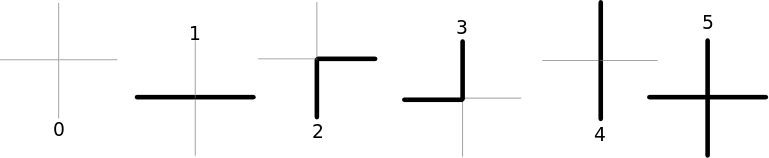

Illustration on how the interactions between vertices look like in our model of the scars. The letter F(A) between two links indicates that the their interaction is (anti-)ferromagnetic.

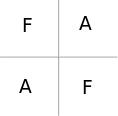

In [2]:
#We construct compatibility arrays.
##> compatibility_y[i,j] is 1(0) if it is (in)compatible to place the vertex j on top of i.
##> compatibility_x[i,j] is 1(0) if it is (in)compatible to place the vertex j to the right of i
### The vertex 6 is used as a place holder and, by construction, will be compatible with all vertices

compatibility_y=zeros((7,7),int)
compatibility_y[0,0]=1
compatibility_y[0,1]=1
compatibility_y[0,3]=1
compatibility_y[1,0]=1
compatibility_y[1,1]=1
compatibility_y[1,3]=1
compatibility_y[2,0]=1
compatibility_y[2,1]=1
compatibility_y[2,3]=1
compatibility_y[3,2]=1
compatibility_y[3,4]=1
compatibility_y[3,5]=1
compatibility_y[4,2]=1
compatibility_y[4,4]=1
compatibility_y[4,5]=1
compatibility_y[5,2]=1
compatibility_y[5,4]=1
compatibility_y[5,5]=1
compatibility_y[6,:]=1
compatibility_y[:,6]=1

compatibility_x=zeros((7,7),int)
compatibility_x[0,0]=1
compatibility_x[0,2]=1
compatibility_x[0,4]=1
compatibility_x[1,1]=1
compatibility_x[1,3]=1
compatibility_x[1,5]=1
compatibility_x[2,1]=1
compatibility_x[2,3]=1
compatibility_x[2,5]=1
compatibility_x[3,0]=1
compatibility_x[3,2]=1
compatibility_x[3,4]=1
compatibility_x[4,0]=1
compatibility_x[4,2]=1
compatibility_x[4,4]=1
compatibility_x[5,1]=1
compatibility_x[5,3]=1
compatibility_x[5,5]=1
compatibility_x[6,:]=1
compatibility_x[:,6]=1

In [3]:
#Observables associated with vertices

#Resulting energy from two links interactions from our model.
energy=zeros(6)
energy[2]=-4
energy[3]=-4

#Total magnetization of each time of vertex
mag=zeros(6)
mag[0]=-1
mag[5]=1

#The two winding direction contributions of each vertex

#Here we consider the value of the top-most vertical link
#While the link is vertical, the label x enphasises that this is used to compute windings in the x direction
windings_x=zeros(6,int)+1
windings_x[0]=-1
windings_x[1]=-1
windings_x[2]=-1

#Here we consider the value of the right-most horizontal link
#While the link is vertical, the label y enphasises that this is used to compute windings in the y direction
windings_y=zeros(6,int)+1
windings_y[0]=-1
windings_y[3]=-1
windings_y[4]=-1

Bellow we find the code for state construction. We have three ways of representing the states:

1. A $L_2\times L_1$ array: entries $st\left[y,x\right]$ take value between 0 and 5 and store the state of that vertex.

2. A "large" number $M$ obtained by flattening the above array and convert it to an integer using base 6.

3. A "small" number $m$ obttained by assigning a number from $0$ to $N-1$ where $N$ is the total number of physical states.

In [4]:
#Construction of states by systematically checking the compatibility of adding
#a new vertex with the existing vertices. By construction, when we try to place 
#a vertex and certain neighbours have not yet been placed, this is is by construction
#always compatible we adding a new vertex.  

def construction_states(L1,L2):
    allowed=[zeros((L2,L1),int)+6]       #The value 6 working as a place holder
    for x in range(L1):
        for y in range(L2):
            new=[]
            for mat in allowed:
                for i in range(6):
                    condition = compatibility_x[i,mat[y,(x+1)%L1]]
                    condition*= compatibility_x[mat[y,(x-1)%L1],i]
                    condition*= compatibility_y[i,mat[(y+1)%L2,x]]
                    condition*= compatibility_y[mat[(y-1)%L2,x],i]
                    if condition==1:
                        state=deepcopy(mat)
                        state[y,x]=i
                        new+=[state]
            allowed=deepcopy(new)
    return allowed

#For obc we simply don't check the closing of the boundary
def construction_states_obc(L1,L2):
    allowed=[zeros((L2,L1),int)+6]
    for x in range(L1):
        for y in range(L2):
            new=[]
            for mat in allowed:
                for i in range(6):
                    condition=1
                    if x<L1-1:
                        condition*= compatibility_x[i,mat[y,(x+1)%L1]]
                    if x>0:
                        condition*= compatibility_x[mat[y,(x-1)%L1],i]
                    if y<L2-1:
                        condition*= compatibility_y[i,mat[(y+1)%L2,x]]
                    if y>0:
                        condition*= compatibility_y[mat[(y-1)%L2,x],i]
                    if condition==1:
                        state=deepcopy(mat)
                        state[y,x]=i
                        new+=[state]
            allowed=deepcopy(new)
    return allowed


#We associate two number to each state: M and m
# M is obtained by flattening the state and then mapped to an integer by
#interpreting each 
def stts_to_dic(stts,L1,L2):
    M2m={}
    m2M={}
    for m,st in enumerate(stts):
        M=int(''.join(map(str,st.flatten())),6)
        m2M[m]=M
        M2m[M]=m
    return M2m, m2M

#Given a basis of states and windings wx and wy, it selects a subset of the
#basis restricted to that winding sector
def winding_sector(wx,wy,stts,L1,L2):
    new_stts=[]
    for st in stts:
        w=sum([windings_y[st[y,0]] for y in range(L2)])
        if w==wy:
            w=sum([windings_x[st[0,x]] for x in range(L1)])
            if w==wx:
                new_stts+=[st]
    return new_stts

## Construction of Operators and other quantities

The image below shoes how the two flippable plaquettes can look like. For each of them, there are two possible vertices. When it flips, it goes to a well defined other vertex. For example: 1<->3, 2<->4 and so on.

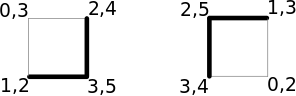

In [5]:
#The kinetic term
def Ok(L1,L2,stts,M2m,m2M):
    N=len(m2M)
    H=zeros((N,N),complex)
    base=array([2**i for i in range(L1*L2)])
    for i,st in enumerate(stts):
        for x in range(L1):
            for y in range(L2):
                if st[y,x] in [1,2] and st[(y+1)%L2,(x+1)%L1] in [2,4]:
                    st_new=zeros((L2,L1),int)+st
                    st_new[y,x]+=2
                    st_new[(y+1)%L2,(x+1)%L1]-=1
                    st_new[y,(x+1)%L1]-=3
                    st_new[(y+1)%L2,x]+=2
                    M=int(''.join(map(str,st_new.flatten())),6)
                    H[i,M2m[M]]=-1
                elif st[y,x] in [3,4] and st[(y+1)%L2,(x+1)%L1] in [1,3]:
                    st_new=zeros((L2,L1),int)+st
                    st_new[y,x]-=2
                    st_new[(y+1)%L2,(x+1)%L1]+=1
                    st_new[y,(x+1)%L1]+=3
                    st_new[(y+1)%L2,x]-=2
                    M=int(''.join(map(str,st_new.flatten())),6)
                    H[i,M2m[M]]=-1
    return H

#The potential term of the original RK model
def Op(L1,L2,stts,M2m,m2M):
    N=len(m2M)
    H=zeros((N,N),complex)
    base=array([2**i for i in range(L1*L2)])
    for i,st in enumerate(stts):
        for x in range(L1):
            for y in range(L2):
                if st[y,x] in [1,2] and st[(y+1)%L2,(x+1)%L1] in [2,4]:
                    H[i,i]+=1
                elif st[y,x] in [3,4] and st[(y+1)%L2,(x+1)%L1] in [1,3]:
                    H[i,i]+=1
    return H

In [6]:
#Shannon entropy defined for a given state
def shannon_st(st):
    s=0
    for a in st:
        if abs(a)>0.000000001:
            s-=abs(a**2)*log(abs(a**2))
    return s

In [7]:
def Ecorr_sum(L1,L2,basis):
    N=len(len(basis))
    O=zeros((N,N))
    for i,st in enumerate(basis):
        for x in range(L1):
            E0=sum([windings_x[n] for n in st[:,x]])
            E1=sum([windings_x[n] for n in st[:,(x+1)%L1]])
            O[i,i]+=E0*E1
    return O

## Constructing Large Systems from Smaller Eigenstates

We will construct states of larger systems by putting together states of smaller systems. Mathematically we consider two states that correspond to two system sizes. Say system $A$ has a size $L_{A1}\times L_{A2}$ and system $B$ is $L_{B1}\times L_{B2}$. We assume $L_{A2}=L_{B2}=L_{2}$. We want to concatenate states in order to create a state of a system of size  $\left(L_{A1}+L_{B1}-1\right)\times L_{B2}$. For this case we writte the two states to concatenate in the form:

\begin{equation}
\left|\psi_A\right>
=\sum_{\alpha\in A\ \mathrm{Bulk}}\ \sum_{\beta\in \mathrm{Boundary}} a_{\alpha\beta}
\left|\alpha\right>\otimes\left|\beta\right>
\end{equation}

\begin{equation}
\left|\psi_B\right>
=\sum_{\alpha^\prime\in B\ \mathrm{Bulk}}\ \sum_{\beta\in \mathrm{Boundary}} b_{\beta\alpha^\prime}
\left|\beta\right>\otimes\left|\alpha\right>
\end{equation}

So that we can but the two together by forming the state

\begin{equation}
\left|\psi_{AB}\right>
=\sum_{\alpha,\ \alpha^\prime}\ \sum_{\beta\in \mathrm{Boundary}} a_{\alpha\beta}b_{\beta\alpha^\prime}
\otimes\left|\alpha\right>\otimes\left|\beta\right>\otimes\left|\alpha^{\prime}\right>
\end{equation}

Note that this concatenation does not constitute a problem with boundary condition, even for periodic, as long as they are the same for the two smaller systems.

To perform this, it is useful to start by constructing the states $\beta$ seprately.

In [8]:
def boundary_states_y(L):
    allowed=[zeros((L),int)+6]       #The value 6 working as a place holder
    for y in range(L):
        new=[]
        for mat in allowed:
            for i in range(6):
                condition = compatibility_y[i,mat[(y+1)%L]]
                condition*= compatibility_y[mat[(y-1)%L],i]
                if condition==1:
                    state=deepcopy(mat)
                    state[y]=i
                    new+=[state]
        allowed=deepcopy(new)
    M2m={}
    m2M={}
    for m,st in enumerate(allowed):
        M=int(''.join(map(str,st)),6)
        m2M[m]=M
        M2m[M]=m
    return allowed, M2m, m2M

In [9]:
def glue2states(sta,La1,stb,Lb1,L2,M2m_joint):
    N=len(M2m_joint)
    new_st=zeros((L2,La1+Lb1-1),int)
    new_st[:,:La1]+=sta
    new_st[:,La1:]+=stb[:,1:]
    M=int(''.join(map(str,new_st.flatten())),6)
    return M2m_joint[M]

#There are two sets of independent data being provided here
#Stuff related to system a:
### La1,va,all_sttsa
#Stuff related to system b:
### Lb1, vb,all_sttsb
#We start by going throug the state a and identify connections to boudnary states
#Then the ame thing with the b
#Then we glue them together
def larger_state_construction(La1,va,basisa,
                              Lb1,vb,basisb,
                              L2,all_joint,M2m_joint):
    #Construction of boundary states
    boundary_sts,M2m_boundary,m2M_boundary=boundary_states_y(L2)
    #Construction of glue dictionary
    Nboundary=len(m2M_boundary)
    glue_dic={}
    for i in range(Nboundary):
        glue_dic[m2M_boundary[i]]=[[],[]]
    #Map stats from a to their boundary state 
    for i,a in enumerate(va):
        if abs(a)>10**(-8):
            st_at_bound=basisa[i][:,-1]
            M=int(''.join(map(str,st_at_bound)),6)
            glue_dic[M][0]+=[i]
    #Map stats from b to their boundary state
    for i,b in enumerate(vb):
        if abs(b)>10**(-8):
            st_at_bound=basisb[i][:,0]
            M=int(''.join(map(str,st_at_bound)),6)
            glue_dic[M][1]+=[i]
    #Construction of the joint state
    print(glue_dic)
    N=len(all_joint)
    v_joint=zeros((N))
    for i in range(Nboundary):
        for ia in glue_dic[m2M_boundary[i]][0]:
            for ib in glue_dic[m2M_boundary[i]][1]:
                sta=basisa[ia]
                stb=basisb[ib]
                ind=glue2states(sta,La1,stb,Lb1,L2,M2m_joint)
                v_joint[ind]+=va[ia]*vb[ib]
    return v_joint

In [61]:
boundary_basis,M2m,m2M=boundary_states_y(2)

In [18]:
basis=construction_states(2,2)

In [22]:
for i,b in enumerate(basis):
    print(i)
    print(b)
    print('')

0
[[0 0]
 [0 0]]

1
[[0 4]
 [0 4]]

2
[[0 0]
 [1 1]]

3
[[0 4]
 [1 5]]

4
[[1 1]
 [0 0]]

5
[[1 5]
 [0 4]]

6
[[1 1]
 [1 1]]

7
[[1 5]
 [1 5]]

8
[[2 3]
 [3 2]]

9
[[3 2]
 [2 3]]

10
[[4 0]
 [4 0]]

11
[[4 4]
 [4 4]]

12
[[4 0]
 [5 1]]

13
[[4 4]
 [5 5]]

14
[[5 1]
 [4 0]]

15
[[5 5]
 [4 4]]

16
[[5 1]
 [5 1]]

17
[[5 5]
 [5 5]]



In [38]:
for i,b in enumerate(basis_joint):
    print(i)
    print(b)
    print('')

0
[[0 0 0]
 [0 0 0]]

1
[[0 0 4]
 [0 0 4]]

2
[[0 4 0]
 [0 4 0]]

3
[[0 4 4]
 [0 4 4]]

4
[[0 0 0]
 [1 1 1]]

5
[[0 0 4]
 [1 1 5]]

6
[[0 2 3]
 [1 3 2]]

7
[[0 4 0]
 [1 5 1]]

8
[[0 4 4]
 [1 5 5]]

9
[[1 1 1]
 [0 0 0]]

10
[[1 1 5]
 [0 0 4]]

11
[[1 3 2]
 [0 2 3]]

12
[[1 5 1]
 [0 4 0]]

13
[[1 5 5]
 [0 4 4]]

14
[[1 1 1]
 [1 1 1]]

15
[[1 1 5]
 [1 1 5]]

16
[[1 5 1]
 [1 5 1]]

17
[[1 5 5]
 [1 5 5]]

18
[[2 1 3]
 [3 0 2]]

19
[[2 3 0]
 [3 2 1]]

20
[[2 3 4]
 [3 2 5]]

21
[[2 5 3]
 [3 4 2]]

22
[[3 0 2]
 [2 1 3]]

23
[[3 2 1]
 [2 3 0]]

24
[[3 2 5]
 [2 3 4]]

25
[[3 4 2]
 [2 5 3]]

26
[[4 0 0]
 [4 0 0]]

27
[[4 0 4]
 [4 0 4]]

28
[[4 4 0]
 [4 4 0]]

29
[[4 4 4]
 [4 4 4]]

30
[[4 0 0]
 [5 1 1]]

31
[[4 0 4]
 [5 1 5]]

32
[[4 2 3]
 [5 3 2]]

33
[[4 4 0]
 [5 5 1]]

34
[[4 4 4]
 [5 5 5]]

35
[[5 1 1]
 [4 0 0]]

36
[[5 1 5]
 [4 0 4]]

37
[[5 3 2]
 [4 2 3]]

38
[[5 5 1]
 [4 4 0]]

39
[[5 5 5]
 [4 4 4]]

40
[[5 1 1]
 [5 1 1]]

41
[[5 1 5]
 [5 1 5]]

42
[[5 5 1]
 [5 5 1]]

43
[[5 5 5]
 [5 5 5]]

In [23]:
sta=basis[5]
stb=basis[15]

In [25]:
stb

array([[5, 5],
       [4, 4]])

In [26]:
basis_joint=construction_states(3,2)

In [27]:
M2m_join,m2M_joint=stts_to_dic(basis_joint,3,2)

In [36]:
glue2states(sta=sta,La1=2,stb=stb,Lb1=2,L2=2,M2m_joint=M2m_join)

13

In [37]:
basis_joint[13]

array([[1, 5, 5],
       [0, 4, 4]])

In [ ]:
larger_state_construction(La1,va,basisa,M2ma,m2Ma,
                              Lb1,vb,basisb,M2mb,m2Mb,
                              L2,all_joint,M2m_joint,m2M_joint)

In [43]:
va=zeros(len(basis))
va[0]=.1;va[5]=.6;va[15]=-sqrt(1-va[0]**2-va[5]**2)
print(va)

[ 0.1         0.          0.          0.          0.          0.6
  0.          0.          0.          0.          0.          0.
  0.          0.          0.         -0.79372539  0.          0.        ]


In [45]:
vb=zeros(len(basis_joint))
vb[2]=.2;vb[36]=.36;vb[37]=-sqrt(1-vb[2]**2-vb[36]**2)
print(vb)

[ 0.          0.          0.2         0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.36       -0.91126286  0.          0.          0.          0.
  0.          0.        ]


In [47]:
new_basis=construction_states(4,2)
new_M2m,new_m2M=stts_to_dic(new_basis,4,2)

In [48]:
va[5]*vb[36]

0.216

In [49]:
va[5]*vb[37]

-0.5467577159949368

In [50]:
va[15]*vb[36]

-0.28574114159497577

In [51]:
va[15]*vb[37]

0.7232924719641426

In [52]:
va[0]*vb[2]

0.020000000000000004

In [69]:
vf=larger_state_construction(La1=2,va=va,basisa=basis,
                              Lb1=3,vb=vb,basisb=basis_joint,
                              L2=2,all_joint=new_basis,M2m_joint=new_M2m)

{0: [[0], [2]], 1: [[], []], 6: [[], []], 7: [[], []], 15: [[], []], 20: [[], []], 28: [[], []], 29: [[], []], 34: [[5, 15], [36, 37]], 35: [[], []]}


In [71]:
for i,c in enumerate(vf):
    if abs(c)>10**-5:
        print(i,c)

2 0.020000000000000004
32 0.216
33 -0.5467577159949368
102 -0.28574114159497577
103 0.7232924719641426


In [80]:
new_basis[103]

array([[5, 5, 3, 2],
       [4, 4, 2, 3]])

In [81]:
new_basis[33]

array([[1, 5, 3, 2],
       [0, 4, 2, 3]])

In [62]:
boundary_basis

[array([0, 0]),
 array([0, 1]),
 array([1, 0]),
 array([1, 1]),
 array([2, 3]),
 array([3, 2]),
 array([4, 4]),
 array([4, 5]),
 array([5, 4]),
 array([5, 5])]

## Some Calculations for a $10\times2$ System at $\left(0,0\right)$ Winding

In [10]:
#Construction of all gauge invariant states for a 10x2 lattice
stts_L102 = construction_states(10,2)

Total number of states matches the paper (arXiv:2012.08540)

In [12]:
print(len(stts_L102))

61098


In [11]:
#Reduction of the basis to the winding (0,0) sector
stts_L102_w00=winding_sector(0,0,stts_L102,10,2)

Again, the number of states in this sector also matches (arXiv:2012.08540)

In [86]:
print(len(stts_L102_w00))

17906


We proceed with the check of density of states and entanglement entropy

In [12]:
#Construction of the dictionaries
M2m_L102_w00,m2M_L102_w00=stts_to_dic(stts_L102_w00,10,2)

In [13]:
#Construction of the operators of the Hamiltonian
Ok_L102_w00=Ok(10,2,stts_L102_w00,M2m_L102_w00,m2M_L102_w00)
Op_L102_w00=Op(10,2,stts_L102_w00,M2m_L102_w00,m2M_L102_w00)

### $\lambda=0$

In [19]:
#Construction of eigenvectors and eigenvalues
w_L102_w00,v_L102_w00=eigh(Ok_L102_w00)

In [26]:
#Dumping or loading the eigenvectors and eigenvalues

#file = open('/scratch/scars_data/evalues_evectors_L102_w00', 'wb')
#pickle.dump(w_L102_w00,file)
#pickle.dump(v_L102_w00,file)
#file.close()
file = open('/scratch/scars_data/evalues_evectors_L102_w00','rb')
w_L102_w00=pickle.load(file)
v_L102_w00=pickle.load(file)
file.close()

In [35]:
#Clear when no longer necessary
del(w_L102_w00)
del(v_L102_w00)

#### Density of States

<IPython.core.display.Javascript object>


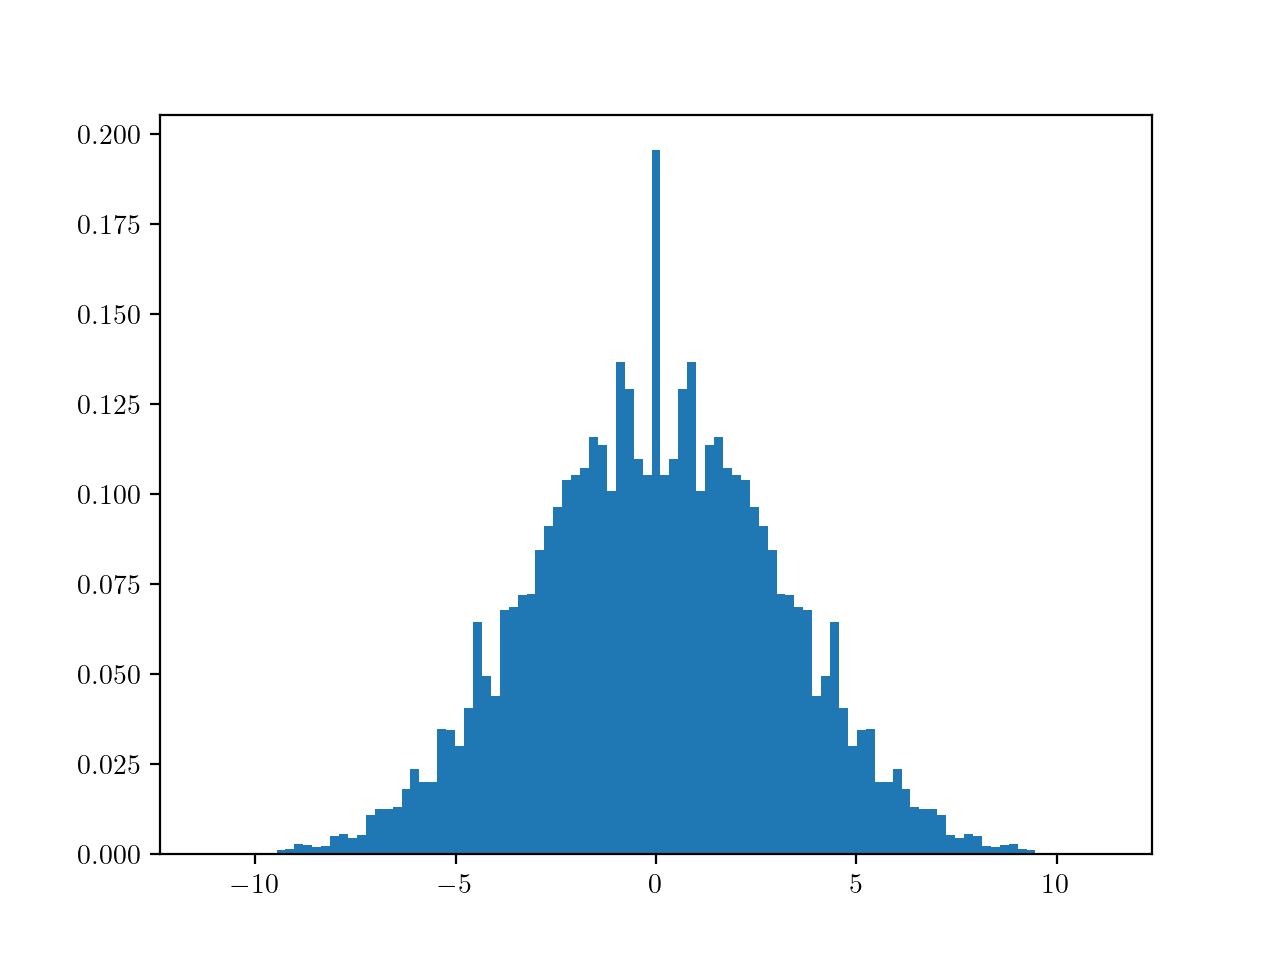

In [27]:
hist(w_L102_w00,bins=101,density=True);

#### Shannon Entropy

In [28]:
sh_L102_w00=[shannon_st(v_L102_w00[:,i]) for i in range(len(v_L102_w00))]

In [30]:
#Dumping or loading the shannon entropy

#file = open('/scratch/scars_data/shannon_L102_w00', 'wb')
#pickle.dump(sh_L102_w00,file)
#file.close()
file = open('/scratch/scars_data/shannon_L102_w00','rb')
sh_L102_w00=pickle.load(file)
file.close()

<IPython.core.display.Javascript object>


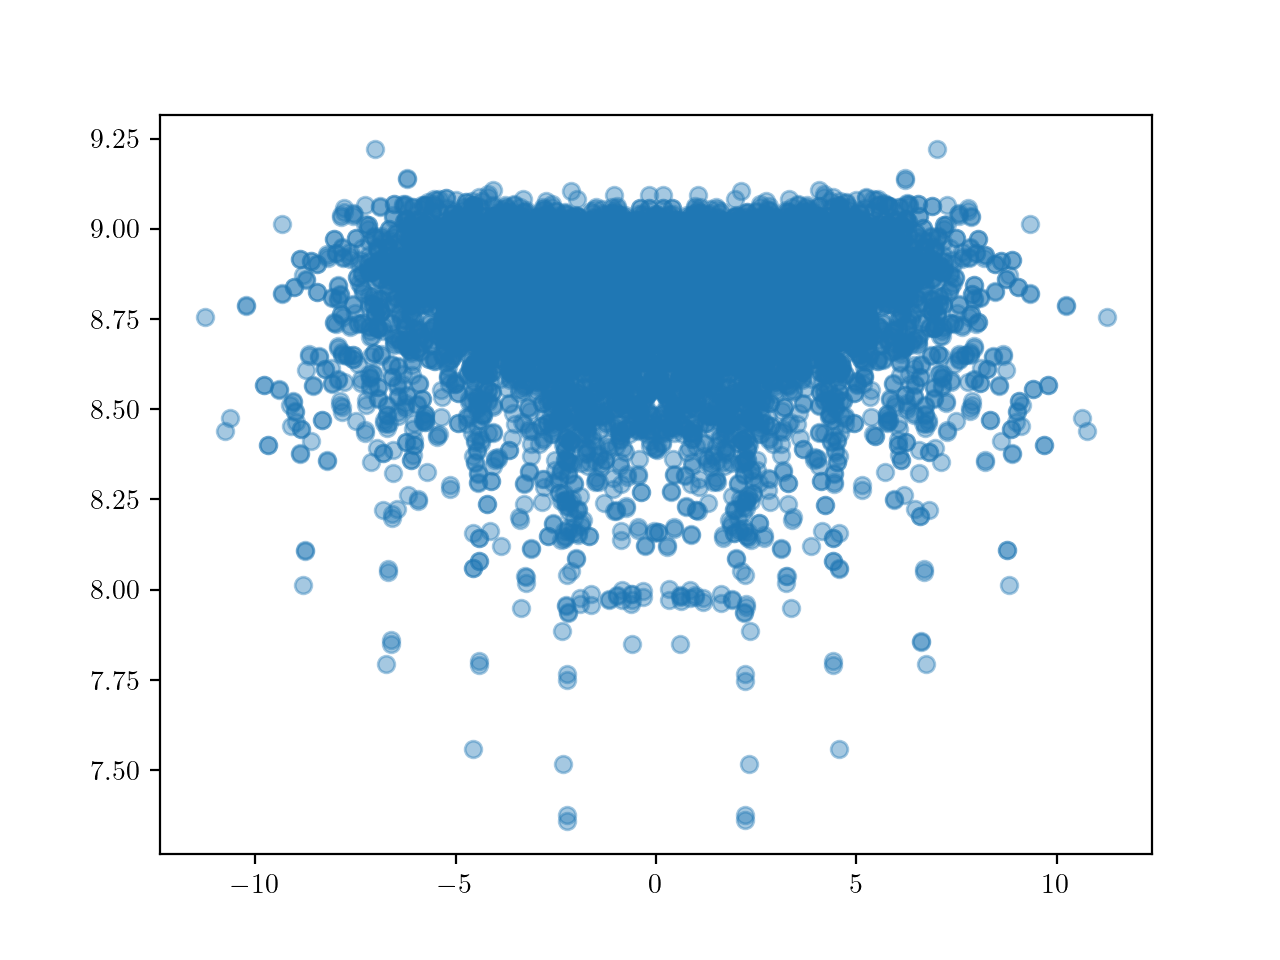

In [33]:
plot(w_L102_w00,sh_L102_w00,'o',alpha=.4)

### $\lambda=-1$

In [14]:
#Construction of eigenvectors and eigenvalues
w_L102_w00_lamb1,v_L102_w00_lamb1=eigh(Ok_L102_w00-Op_L102_w00)

TypeError: __init__() missing 1 required positional argument: 'dtype'

In [42]:
#Dumping or loading the eigenvectors and eigenvalues

#file = open('/scratch/scars_data/evalues_evectors_L102_w00_lamb1', 'wb')
#pickle.dump(w_L102_w00_lamb1,file)
#pickle.dump(v_L102_w00_lamb1,file)
#file.close()
file = open('/scratch/scars_data/evalues_evectors_L102_w00_lamb1','rb')
w_L102_w00_lamb1=pickle.load(file)
v_L102_w00_lamb1=pickle.load(file)
file.close()

In [41]:
#Clear when no longer necessary
del(w_L102_w00_lamb1)
del(v_L102_w00_lamb1)

<IPython.core.display.Javascript object>


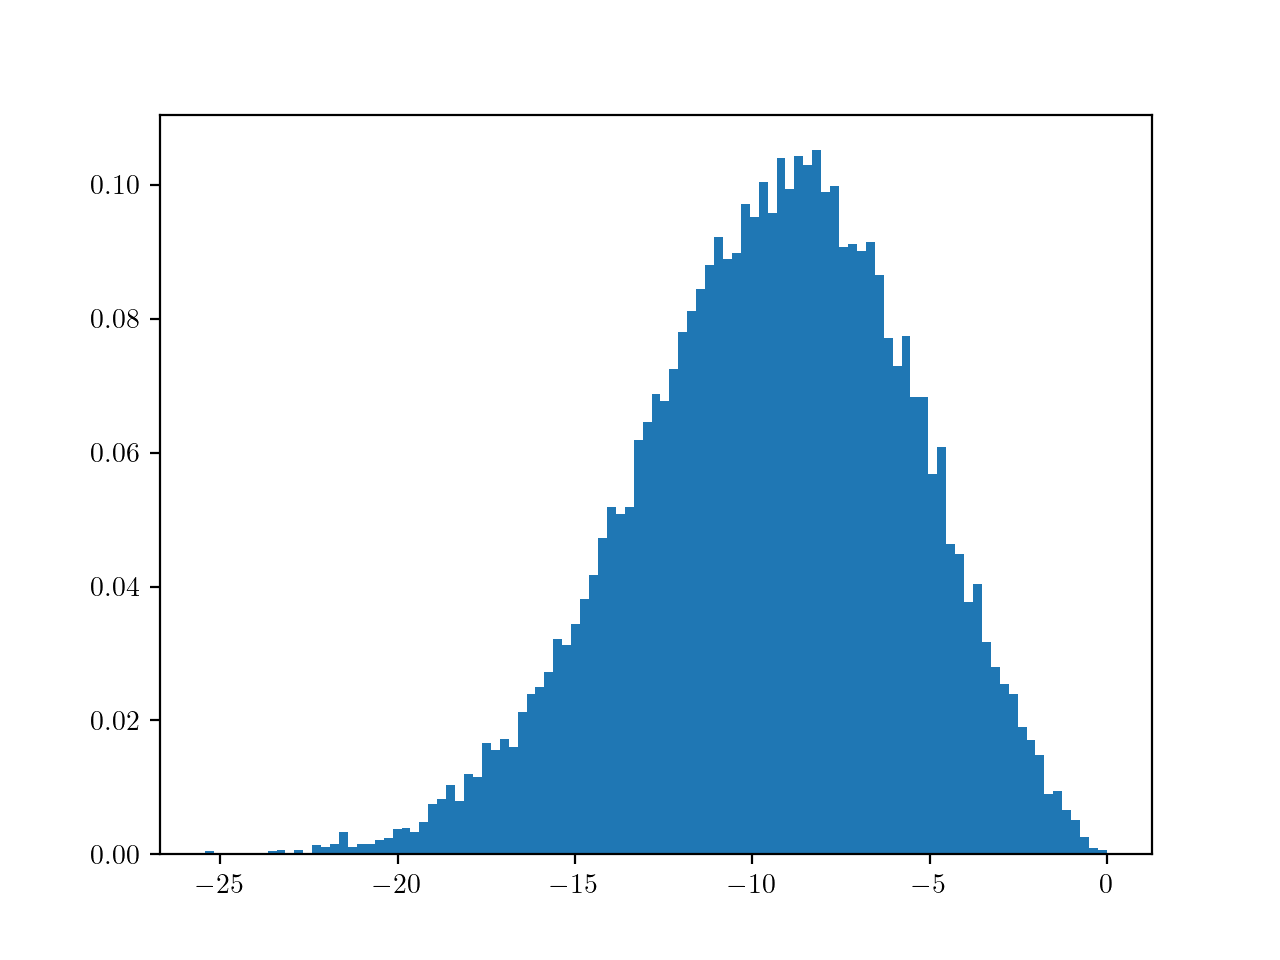

In [40]:
hist(w_L102_w00_lamb1,bins=101,density=True);

#### Shannon Entropy

In [43]:
sh_L102_w00_lamb1=[shannon_st(v_L102_w00_lamb1[:,i]) for i in range(len(v_L102_w00_lamb1))]

In [2]:
#Dumping or loading the shannon entropy

#file = open('/scratch/scars_data/shannon_L102_w00_lamb1', 'wb')
#pickle.dump(sh_L102_w00_lamb1,file)
#file.close()
file = open('/scratch/scars_data/shannon_L102_w00_lamb1','rb')
sh_L102_w00_lamb1=pickle.load(file)
file.close()

FileNotFoundError: [Errno 2] No such file or directory: '/scratch/scars_data/shannon_L102_w00_lamb1'

<IPython.core.display.Javascript object>


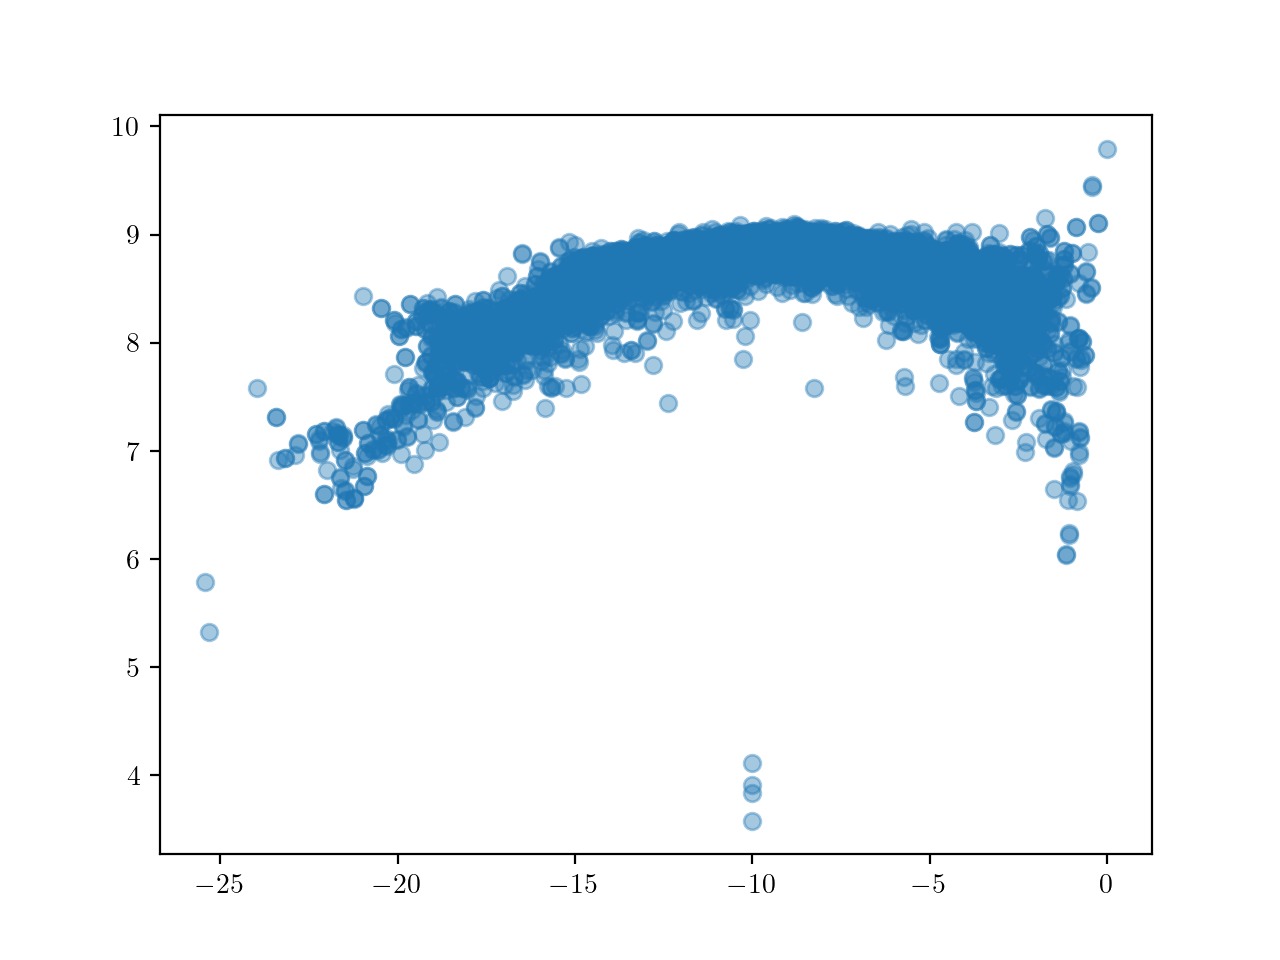

In [45]:
plot(w_L102_w00_lamb1,sh_L102_w00_lamb1,'o',alpha=.4)

#### Time Evolution

In [ ]:
H=Ok_L102_w00-O0_L102_w00

DO ENTANGLEMENT ENTROPY

## Investigating Small System Sizes $L_x\times2$ at $\left(0,0\right)$ Winding

In [7]:
Llst=[6,4,2]
lamb_lst=arange(.0,-1.2,-.1)
data={}
for l in Llst:
    print(l)
    data[l]={}
    data[l]['states'] = construction_states(l,2)
    data[l]['states_w00'] = winding_sector(0,0,data[l]['states'],l,2)
    data[l]['M2m_w00'],data[l]['m2M_w00']=stts_to_dic(data[l]['states_w00'],l,2)
    data[l]['lamb_lst']=lamb_lst
    data[l]['sh']=[]
    data[l]['w']=[]
    Operk=Ok(l,2,data[l]['states_w00'],data[l]['M2m_w00'],data[l]['m2M_w00'])
    Operp=Op(l,2,data[l]['states_w00'],data[l]['M2m_w00'],data[l]['m2M_w00'])
    for lamb in lamb_lst:
        w,v=eigh(Operk+lamb*Operp)
        data[l]['sh']+=[[shannon_st(v[:,i]) for i in range(len(v))]]
        data[l]['w']+=[w]

6
4
2


<IPython.core.display.Javascript object>


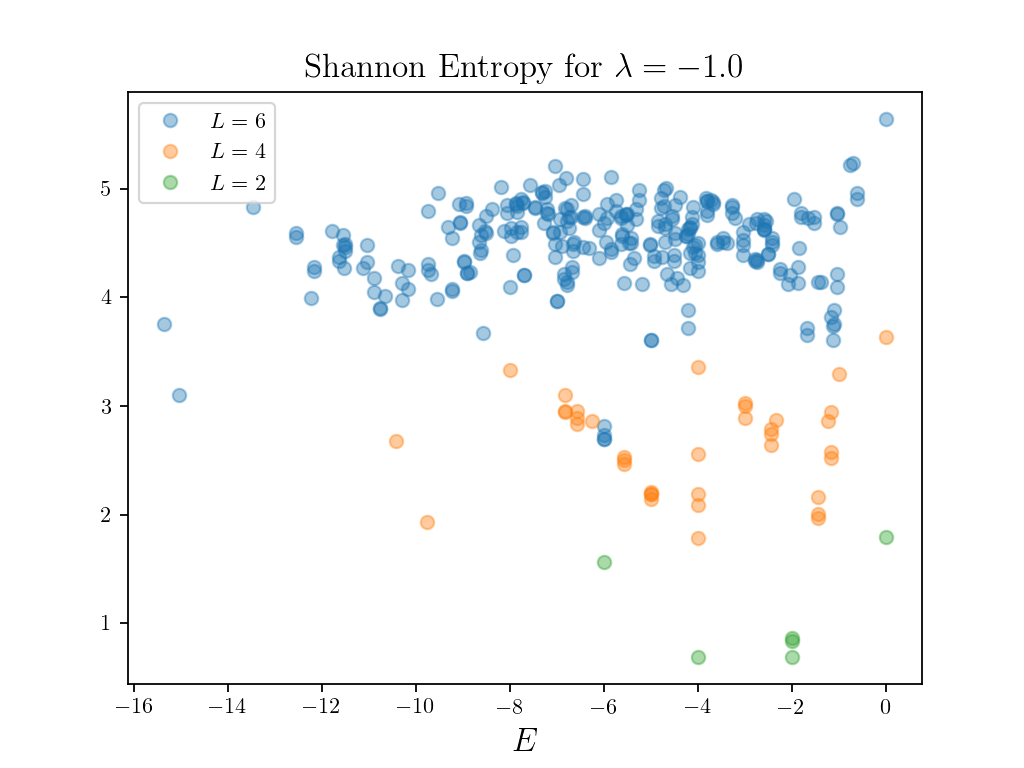

In [36]:
for l in Llst:
    plot(data[l]['w'][-2],data[l]['sh'][-2],'o',alpha=.4,label=r'$L={}$'.format(l))
xlabel('$E$',size=15)
title('Shannon Entropy for $\lambda={}$'.format(data[l]['lamb_lst'][-2]),size=15)
legend(loc=0)

<IPython.core.display.Javascript object>


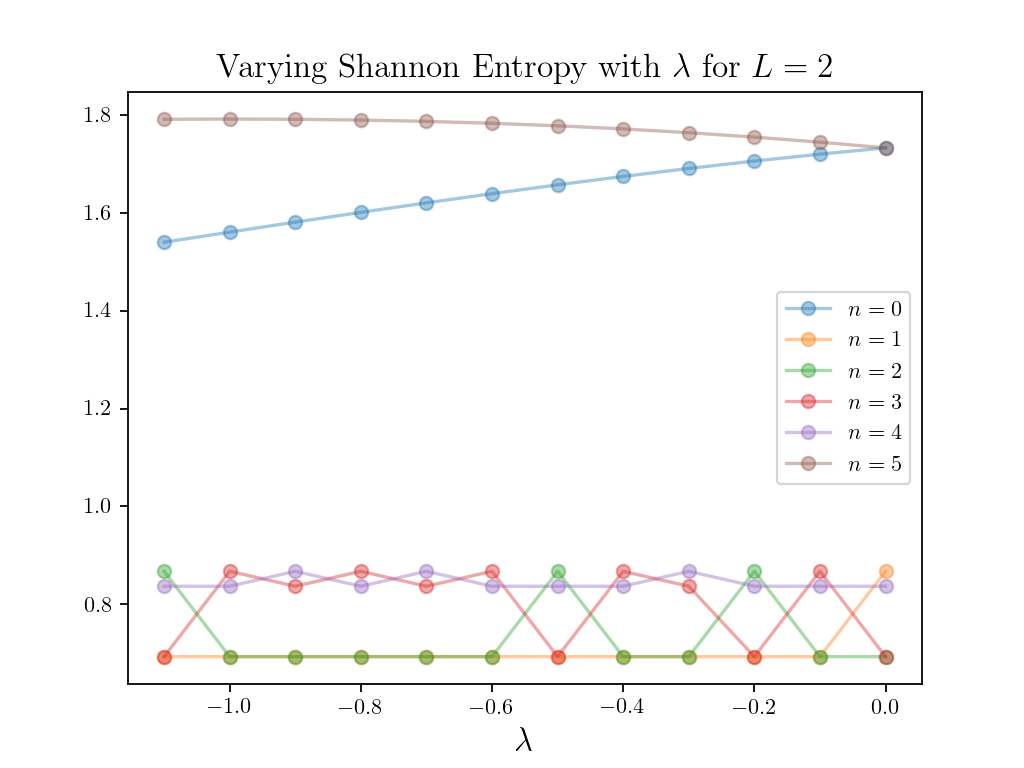

In [38]:
l=2
for i in range(len(data[l]['w'][0])):
    yy=[data[l]['sh'][j][i] for j in range(len(data[l]['lamb_lst']))]
    plot(data[l]['lamb_lst'],yy,'o-',label=r'$n={}$'.format(i),alpha=.4)
xlabel('$\lambda$',size=15)
title('Varying Shannon Entropy with $\lambda$ for $L=2$',size=15)
legend(loc=0)

**Analysis**: For one side, it is quite suggestive that in the $2\times 2$ system there are exactly 4 persistent low entropy states and that we will end up with exactly 4 scars in longer ladders. At the same time, once we look at the $4\times 2$ it is no longer easy to identify where are the proto-scars. In the $6\times 2$, there are again 4 obvious candidates for scars.

In [ ]:
#Investigating thermalization from different initial states

**TODO**
- Entanglement entropy
- Open boundary conditions
- Real time evolution from different states
- Verify if these are really proto scars: can we build large superpositions with large scar states from such building blocks?

In [46]:
w,v=eigh(Ok82-Op82)

In [83]:
sh=[shannon_st(v[:,i]) for i in range(len(v))]

<IPython.core.display.Javascript object>


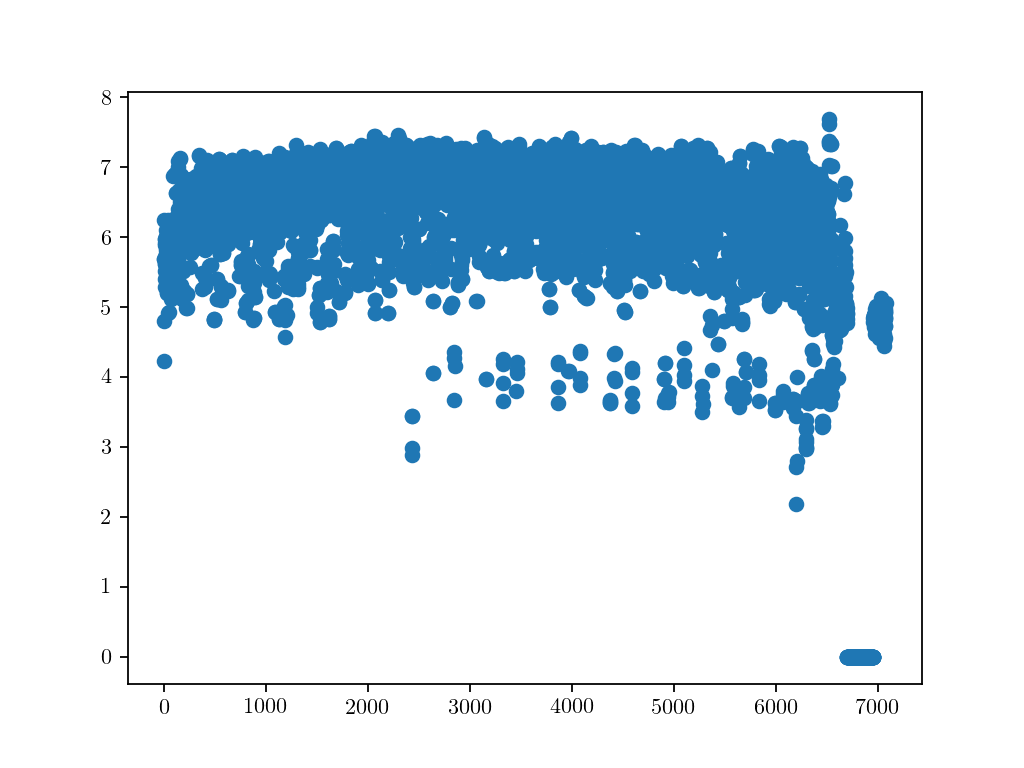

In [85]:
plot(range(len(sh)),sh,'o')

In [7]:
#The potential term of our effective model
def Op_effective(L1,L2,stts,M2m,m2M):
    N=len(m2M)
    H=zeros((N,N),complex)
    base=array([2**i for i in range(L1*L2)])
    for i,st in enumerate(stts):
        for x in range(L1):
            for y in range(L2):
                H[i,i]+=energy[st[y,x]]
    return H

In [9]:
#Total magnetization of the system
def Elect(L1,L2,stts,M2m,m2M):
    N=len(m2M)
    H=zeros((N,N),complex)
    for i,st in enumerate(stts):
        for x in range(L1):
            for y in range(L2):
                H[i,i]+=mag[st[y,x]]/2
    return H

In [10]:
#Constructs a list of (diagonal) operator constituted by the sum of all the electric
#fields, for every x, along the y links.
#Useful to compute correlations between different lines, afterwards
def Eoperators(L1,L2,stts):
    N=len(stts)
    lst=[]
    for x in range(L1):
        lst+=[zeros((N,N))]
        for i,st in enumerate(stts):
            for y in range(L2):
                v=st[y,x]
                lst[-1][i,i]+=int(v>=3)-int(v<3)
    return lst

#Sum of the product of successive operators defined above
def Ecorr(L1,L2,stts):
    Es=Eoperators(L1,L2,stts)
    op=dot(Es[-1],Es[0])
    for x in range(L1-1):
        op+=dot(Es[x],Es[x+1])
    return op

In [16]:
w00=winding_sector(0,0,stts8_2,8,2)

In [17]:
M2m_00,m2M_00=stts_to_dic(w00,8,2)

In [18]:
Ok82_00=Ok(8,2,w00,M2m_00,m2M_00)
Op82_00=Op(8,2,w00,M2m_00,m2M_00)

In [19]:
Os82_00=Op(8,2,w00,M2m_00,m2M_00)

In [113]:
w,v=eigh(Ok82_00-Op82_00)

In [114]:
ws,vs=eigh(Ok82_00-.5*Os82_00)

In [24]:
sh=[shannon_st(v[:,i]) for i in range(len(v))]

In [39]:
shs=[shannon_st(vs[:,i]) for i in range(len(v))]

<IPython.core.display.Javascript object>


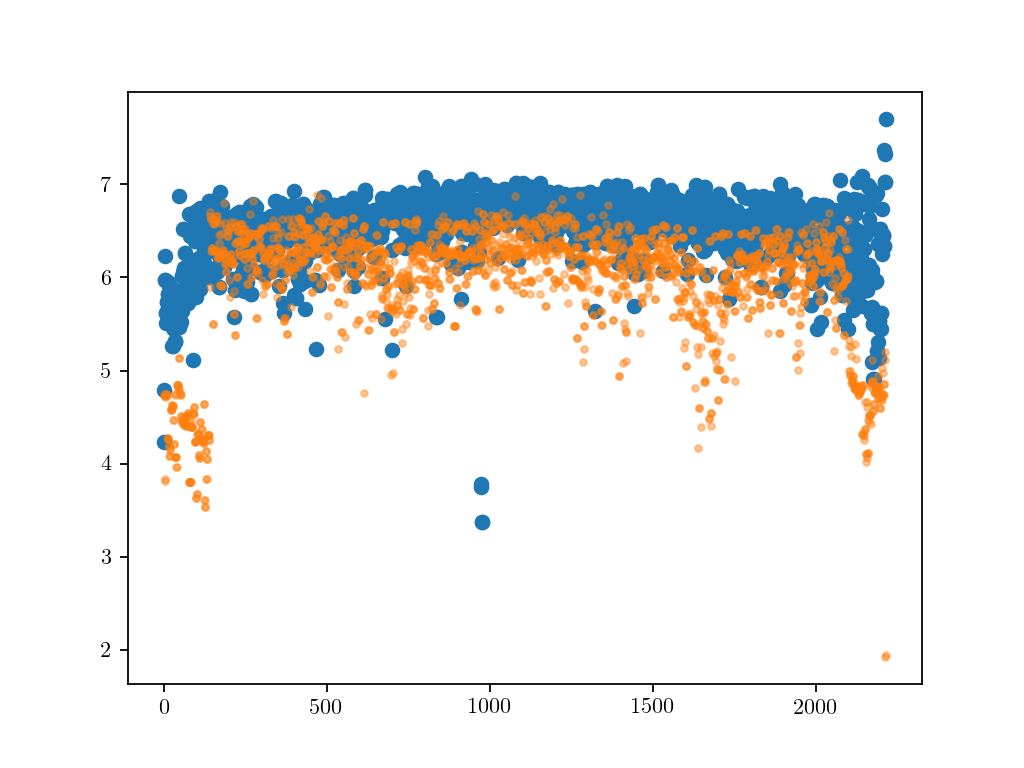

In [99]:
plot(range(len(sh)),sh,'o')
plot(range(len(shs)),shs,'.',alpha=.4)

In [109]:
Ecorr_op=Ecorr(8,2,w00)

In [115]:
ecorrs=[dot(conjugate(v[:,i]),dot(Ecorr_op,v[:,i])) for i in range(len(v))]

In [118]:
ecorrs_sim=[dot(conjugate(vs[:,i]),dot(Ecorr_op,vs[:,i])) for i in range(len(v))]

<IPython.core.display.Javascript object>


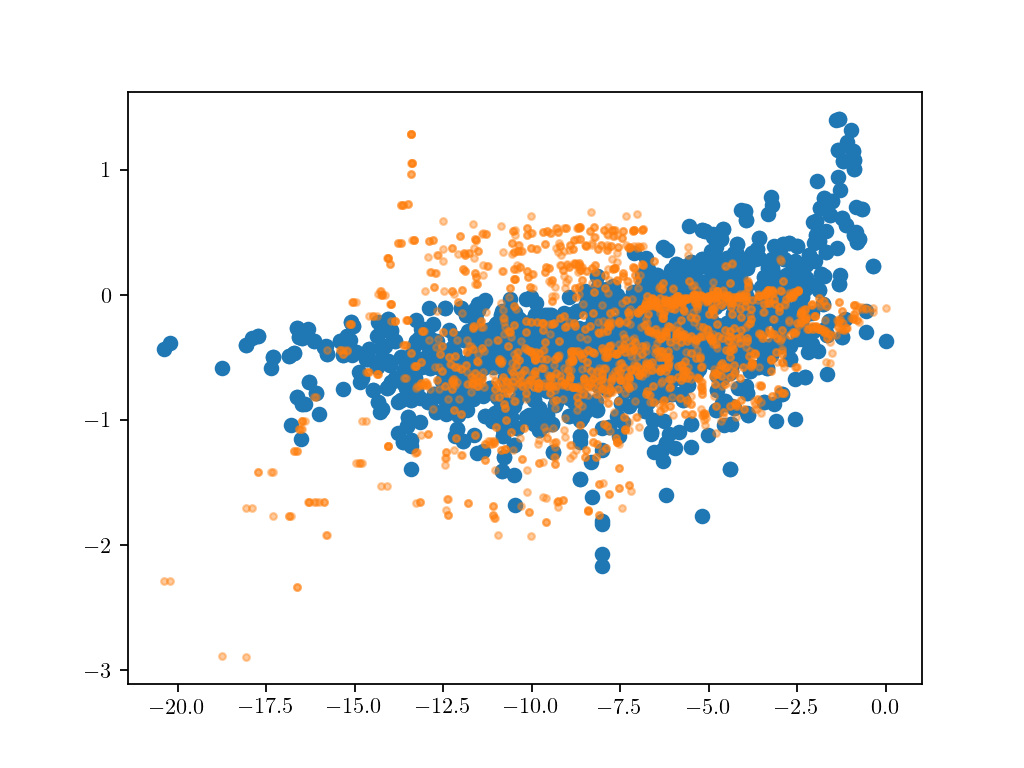

In [120]:
plot(w,real(ecorrs)/8,'o')
plot(w,real(ecorrs_sim)/8,'.',alpha=.4)

In [ ]:
base=array([2**i for i in range(16)])
evol1=[]
evol_s1=[]
evol2=[]
evol_s2=[]
st1_arr=zeros((8,2),int)
for i in range(0,8,2):
    st1_arr[i+1,0]=4
    st1_arr[i,1]=1
    st1_arr[i+1,1]=5
M=dot(base,st1_arr.flatten())
m=M2m_00[M]
st1=zeros(len(M2m_00),complex)
st1[m]=1
st2=dot(Ok82_00,st1)
st1_s=deepcopy(st1)
st2_s=deepcopy(st2)
for t in arange(0,33,3):
    U=expm(-1.j*t*(Ok-Op))
    st1=dot(U,st1)
    st2=dot(U,st2)
    evol1+=[dot(conjugate(st1),dot(Ecorr_o,st1))]
    evol2+=[dot(conjugate(st2),dot(Ecorr_o,st2))]
    U=expm(-1.j*t*(Ok-Os))
    st1_s=dot(U,st1_s)
    st2_s=dot(U,st2_s)
    evol_s1+=[dot(conjugate(st1),dot(Ecorr_o,st1))]
    evol_s2+=[dot(conjugate(st2),dot(Ecorr_o,st2))]

In [76]:
elect=Elect(8,2,w00,M2m_00,m2M_00)

In [77]:
elect2=dot(elect,elect)

In [20]:
rk=[]
si=[]
scrk=[]
scsi=[]
t0=time()
for lamb in arange(-2.,2.1,.04):
    w,v=eigh(Ok82_00-lamb*Op82_00)
    rk+=[w[1]-w[0]]
    #scrk+=[dot(conjugate(v[:,0]),dot(elect2,v[:,0]))-dot(conjugate(v[:,0]),dot(elect,v[:,0]))**2]
    w,v=eigh(Ok82_00-lamb*Os82_00)
    si+=[w[1]-w[0]]
    #scsi+=[dot(conjugate(v[:,0]),dot(elect2,v[:,0]))-dot(conjugate(v[:,0]),dot(elect,v[:,0]))**2]
print(time()-t0)

KeyboardInterrupt: 

In [21]:
len(rk)

102

In [20]:
#file = open('gap8x2', 'wb')
#pickle.dump(rk,file)
#pickle.dump(si,file)
#file.close()
file = open('gap8x2','rb')
rk=pickle.load(file)
si=pickle.load(file)
file.close()

In [21]:
rk=rk[:-1]

In [16]:
arange(-2.,2.02,.04)

2.0000000000000036

In [123]:
for lamb in arange(2.1,3.1,.02):
    w,v=eigh(Ok82_00-lamb*Op82_00)
    rk+=[w[1]-w[0]]
    #scrk+=[dot(conjugate(v[:,0]),dot(elect2,v[:,0]))-dot(conjugate(v[:,0]),dot(elect,v[:,0]))**2]
    w,v=eigh(Ok82_00-lamb*Os82_00)
    si+=[w[1]-w[0]]
    #scsi+=[dot(conjugate(v[:,0]),dot(elect2,v[:,0]))-dot(conjugate(v[:,0]),dot(elect,v[:,0]))**2]

<IPython.core.display.Javascript object>


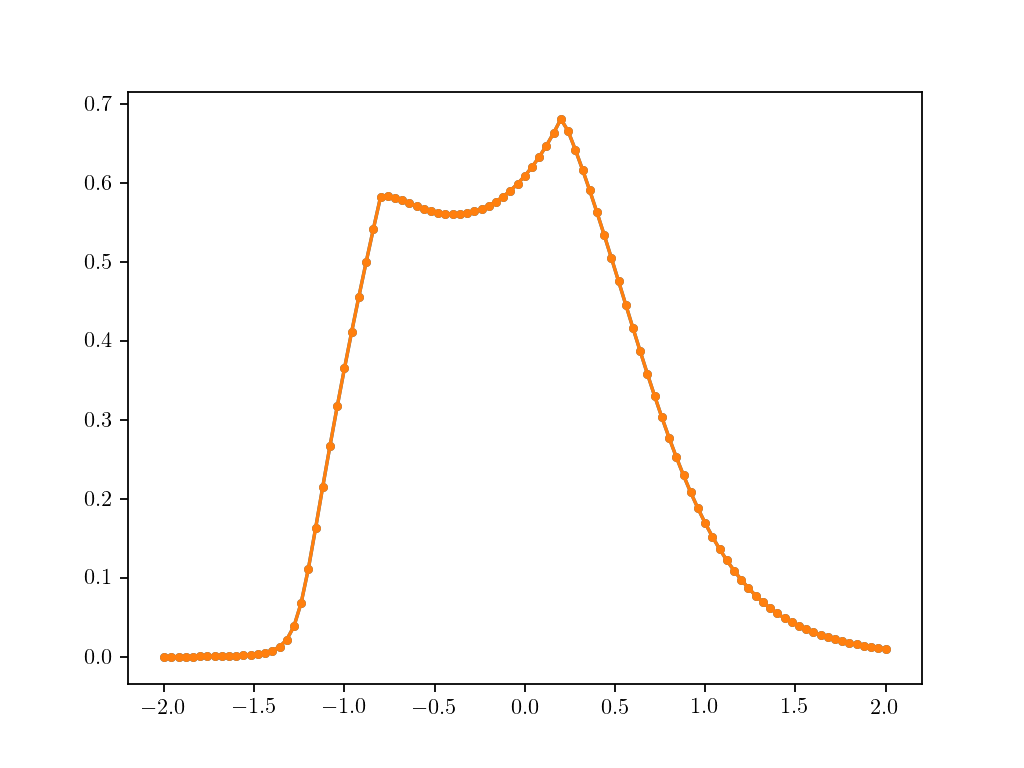

In [22]:
xx=arange(-2.,2.01,.04)
plot(xx,rk,'.-')
plot(xx,si,'.-')

<IPython.core.display.Javascript object>


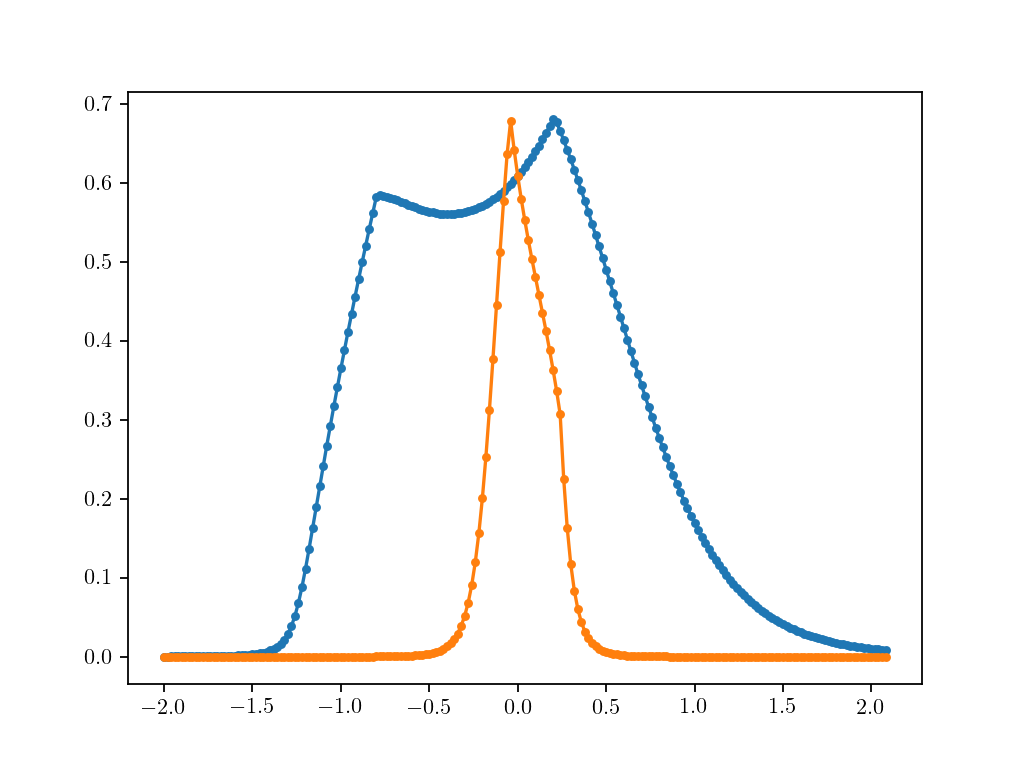

In [95]:
xx=arange(-2.,2.1,.02)
plot(xx,rk,'.-')
plot(xx,si,'.-')

<IPython.core.display.Javascript object>


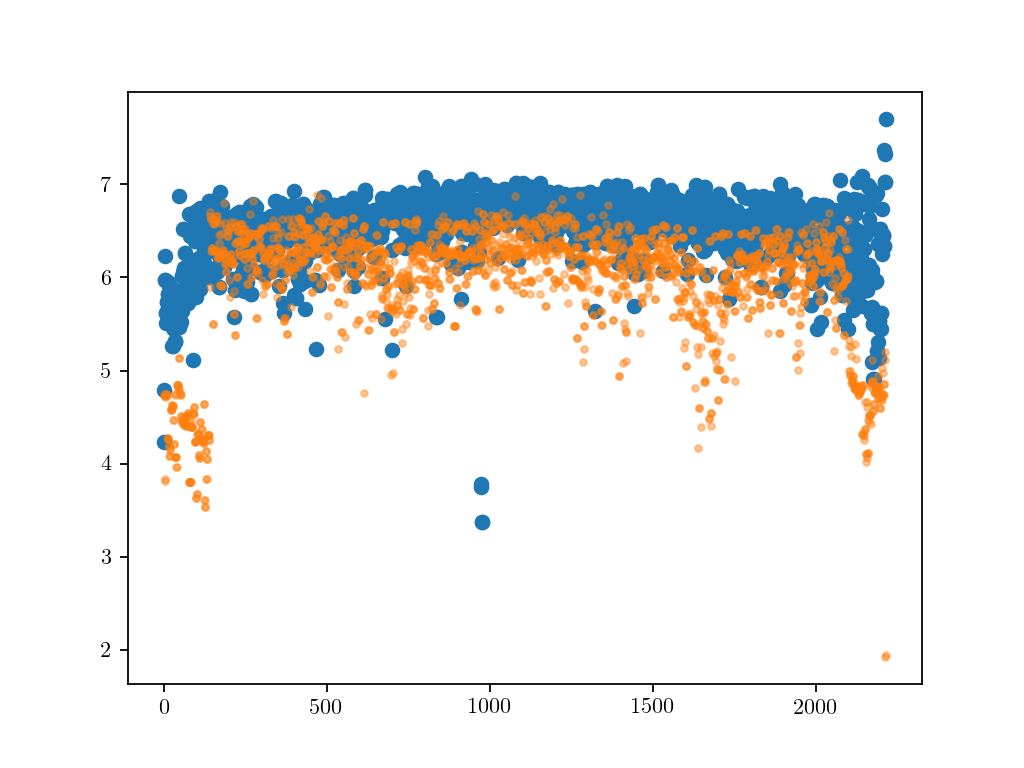

ValueError: x and y must have same first dimension, but have shapes (205,) and (0,)

In [96]:
plot(xx,real(scrk),'.-')
plot(xx,real(scsi),'.-')

In [88]:
dot(conjugate(v[:,0]),dot(elect2,v[:,0]))

0j

In [91]:
for x in range(len(elect[:,0])):
    for y in range(len(elect[0,:])):
        if abs(elect[x,y])>.0001:
            print(x,y,elect[x,y])

In [63]:
w

array([-9.03777503+1.62720128e-17j, -8.42909449+3.69973215e-17j])

In [65]:
lamb=0
w,v=eigs(Ok82_00-lamb*Os82_00,k=2,which='SR')

In [58]:
w

array([ 9.03777503+1.46972457e-18j, -9.03777503+6.12473847e-18j])

In [ ]:
sum(Op82[:,7064])

In [80]:
sum(Op82[:,7064])

0j

In [68]:
for i,x in enumerate(Ok82[:,6944]):
    if abs(x)>.01:
        print(i,x)

3536 (-1+0j)
6943 (-1+0j)


In [82]:
stts8_2[7064]

array([[5, 5, 5, 5, 1, 5, 5, 1],
       [5, 5, 5, 5, 1, 5, 5, 1]])

In [69]:
stts8_2[3536]

array([[2, 5, 5, 5, 5, 5, 5, 3],
       [3, 4, 4, 4, 4, 4, 4, 2]])

In [70]:
stts8_2[6943]

array([[5, 5, 5, 5, 5, 5, 3, 2],
       [4, 4, 4, 4, 4, 4, 2, 3]])

In [84]:
M2m_10_2,m2M_10_2=stts_to_dic(stts10_2,10,2)

In [16]:
M2m_8_2,m2M_8_2=stts_to_dic(stts8_2,8,2)

In [103]:
M2m_2_2,m2M_2_2=stts_to_dic(stts2_2,2,2)

In [17]:
Ok82=Ok(8,2,stts8_2,M2m_8_2,m2M_8_2)
Op82=Op(8,2,stts8_2,M2m_8_2,m2M_8_2)

NameError: name 'H' is not defined

<IPython.core.display.Javascript object>


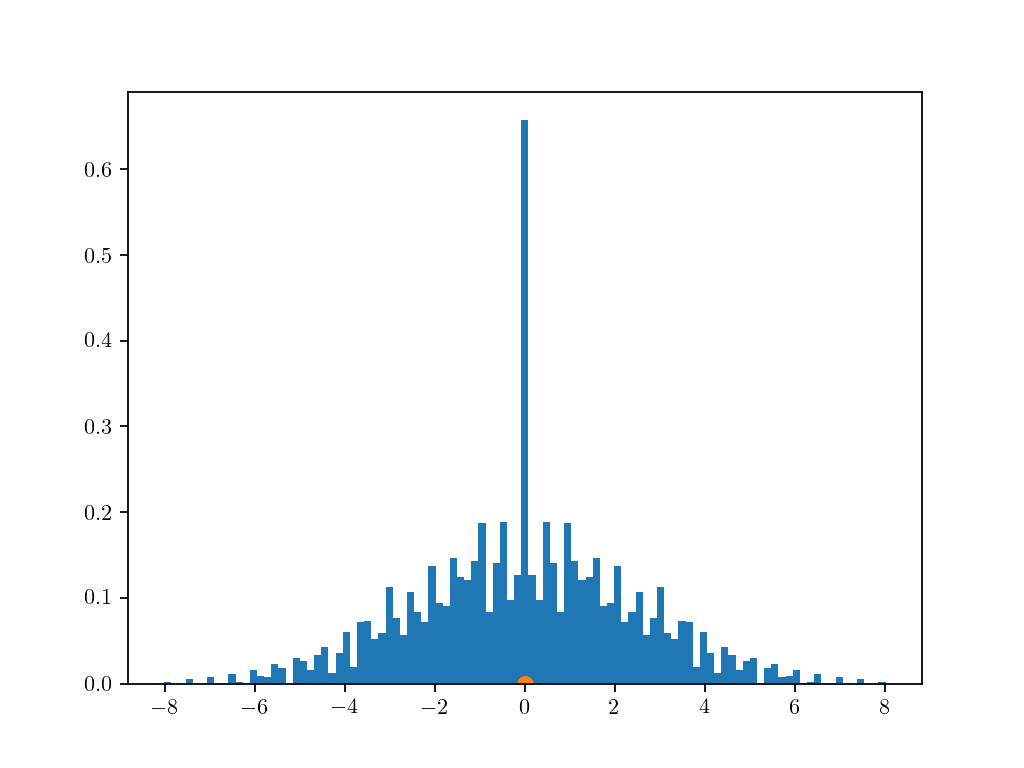

(array([0.00178016, 0.        , 0.        , 0.00534047, 0.        ,
        0.        , 0.00712063, 0.        , 0.        , 0.01068094,
        0.00178016, 0.        , 0.01602141, 0.00890078, 0.00712063,
        0.02314203, 0.01780156, 0.        , 0.03026266, 0.02670235,
        0.01602141, 0.03382297, 0.04272375, 0.01246109, 0.03560313,
        0.06052532, 0.01958172, 0.07120625, 0.07298641, 0.05162453,
        0.05874516, 0.11214985, 0.07654672, 0.056965  , 0.10680938,
        0.08366735, 0.07120625, 0.13707204, 0.09434829, 0.09078797,
        0.14597282, 0.12461094, 0.12105063, 0.14241251, 0.18691642,
        0.08366735, 0.14063235, 0.18869657, 0.0979086 , 0.1263911 ,
        0.65687769, 0.1263911 , 0.0979086 , 0.18869657, 0.14063235,
        0.08366735, 0.18691642, 0.14241251, 0.12105063, 0.12461094,
        0.14597282, 0.09078797, 0.09434829, 0.13707204, 0.07120625,
        0.08366735, 0.10680938, 0.056965  , 0.07654672, 0.11214985,
        0.05874516, 0.05162453, 0.07298641, 0.07

In [129]:
hist(w,bins=101,density=True)

In [19]:
w,v=eigh(Ok82-Op82)

In [22]:
sh=[shannon_st(v[:,i]) for i in range(len(v))]

<IPython.core.display.Javascript object>


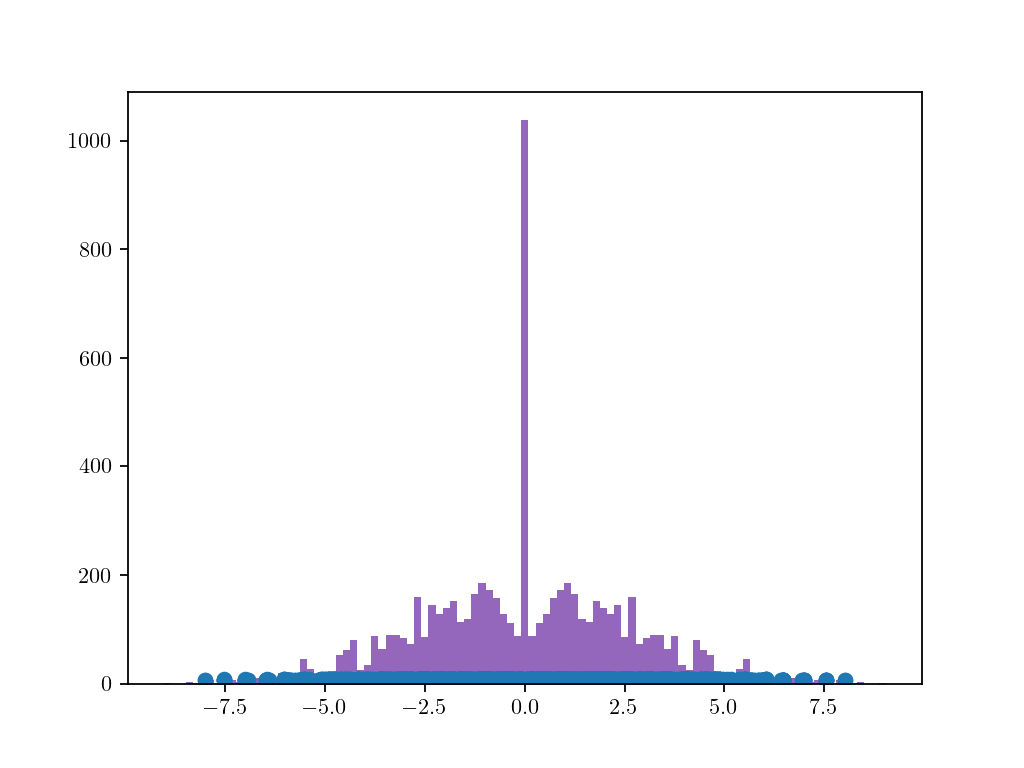

In [26]:
plot(w,sh,'o')

In [27]:
for i,s in enumerate(sh):
    if s<1:
        break
print(i)

3408


In [154]:
plot(range(len(w)),abs(v[:,3408]),'o-')

In [2]:
#file = open('8x2', 'wb')
#pickle.dump(w,file)
#pickle.dump(v,file)
#file.close()
file = open('8x2','rb')
w=pickle.load(file)
v=pickle.load(file)
file.close()

<IPython.core.display.Javascript object>


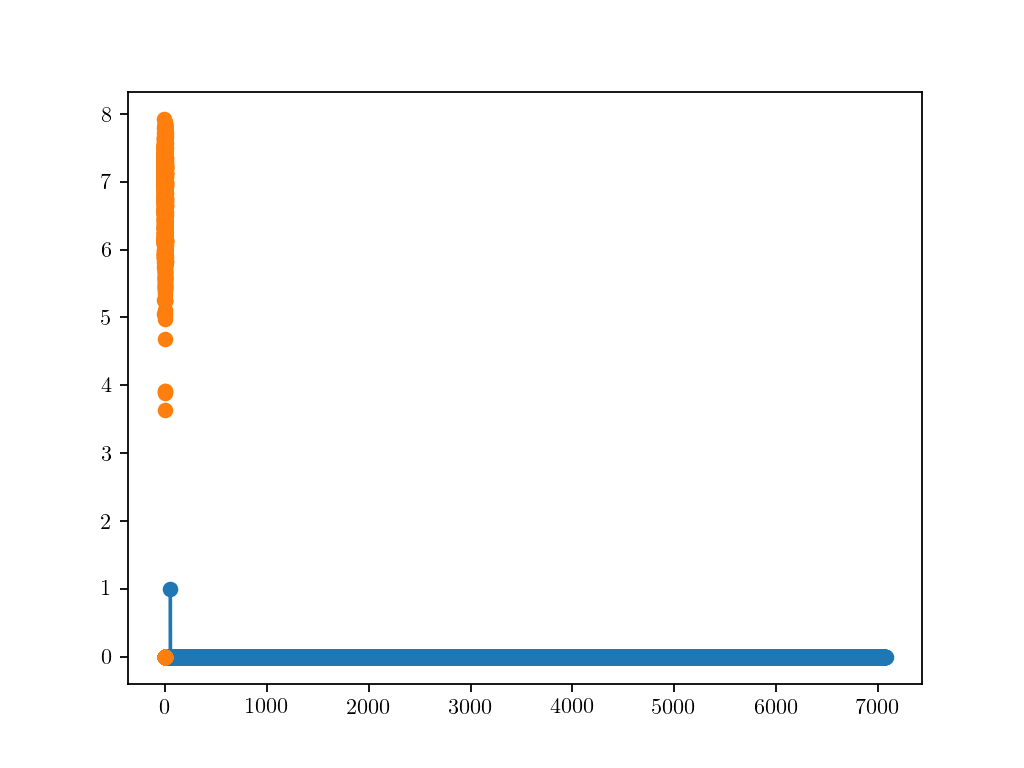

In [3]:
plot(range(len(w)),abs(v[:,3408]),'o-')

In [8]:
stts=construction_states(8,2)
M2m,m2M=stts_to_dic(stts,8,2)

In [9]:
stts[3408]

array([[2, 5, 3, 4, 4, 2, 3, 0],
       [3, 4, 2, 5, 5, 3, 2, 1]])

In [31]:
sum(Op82[:,3048])

0j

In [3]:
def add_site_dimer_ladder(st):
    n=st[-1]
    lst=[]
    if n==1:
        lst=[st+[2]]
    else:
        lst=[st+[0],st+[1]]
    return lst

In [4]:
def st_2_M_dimer_ladder(st):
    return int(''.join(map(str,st)),3)

In [5]:
def build_states_dimer_ladder(L):
    M2m={}
    st_lst=[[0],[1],[2]]
    for i in range(L-1):
        new_lst=[]
        for st in st_lst:
            new_lst+=add_site_dimer_ladder(st)
        st_lst=deepcopy(new_lst)
    count=0
    for st in st_lst:
        M2m[st_2_M_dimer_ladder(st)]=count
        count+=1
    return new_lst,M2m

In [18]:
def Hamiltonian_dimer_ladder(L,st_lst,M2m):
    N=len(st_lst)
    H=zeros((N,N))
    for i,st in enumerate(st_lst):
        #Boundary terms
        if st[0] in [0,2]:
            new_st=[[0,2][int(st[0]==0)]]+st[1:]
            j=M2m[st_2_M_dimer_ladder(new_st)]
            H[j,i]=-1
        if st[-1] in [0,1] and L%2==0:
            new_st=st[:-1]+[[0,1][int(st[0]==0)]]
            j=M2m[st_2_M_dimer_ladder(new_st)]
            H[j,i]=-1
        elif st[-1] in [0,2] and L%2==1:
            new_st=st[:-1]+[[0,2][int(st[0]==0)]]
            j=M2m[st_2_M_dimer_ladder(new_st)]
            H[j,i]=-1
        #Bulk terms
        for j,n in enumerate(st[:-1]):
            if st[j:j+2] in [[0,0],[1,2]]:
                new_st=st[:j]+[[0,0],[1,2]][int(st[j]==0)]+st[j+2:]
                j=M2m[st_2_M_dimer_ladder(new_st)]
                H[j,i]=-1
    return H

def potential_dimer_ladder(L,st_lst):
    N=len(st_lst)
    H=zeros((N,N))
    for i,st in enumerate(st_lst):
        #Boundary terms
        if st[0] in [0,2]:
            H[i,i]+=1
        if st[-1] in [0,1] and L%2==0:
            H[i,i]+=1
        elif st[-1] in [0,2] and L%2==1:
            H[i,i]+=1
        #Bulk terms
        for j,n in enumerate(st[:-1]):
            if st[j:j+2] in [[0,0],[1,2]]:
                H[i,i]+=1
    return H

In [19]:
L=4
st_lst,M2m=build_states_dimer_ladder(L)
H=Hamiltonian_dimer_ladder(L,st_lst,M2m)

In [20]:
w,v=eigh(H)
sh=[shannon_st(v[:,i]) for i in range(len(v))]

<IPython.core.display.Javascript object>


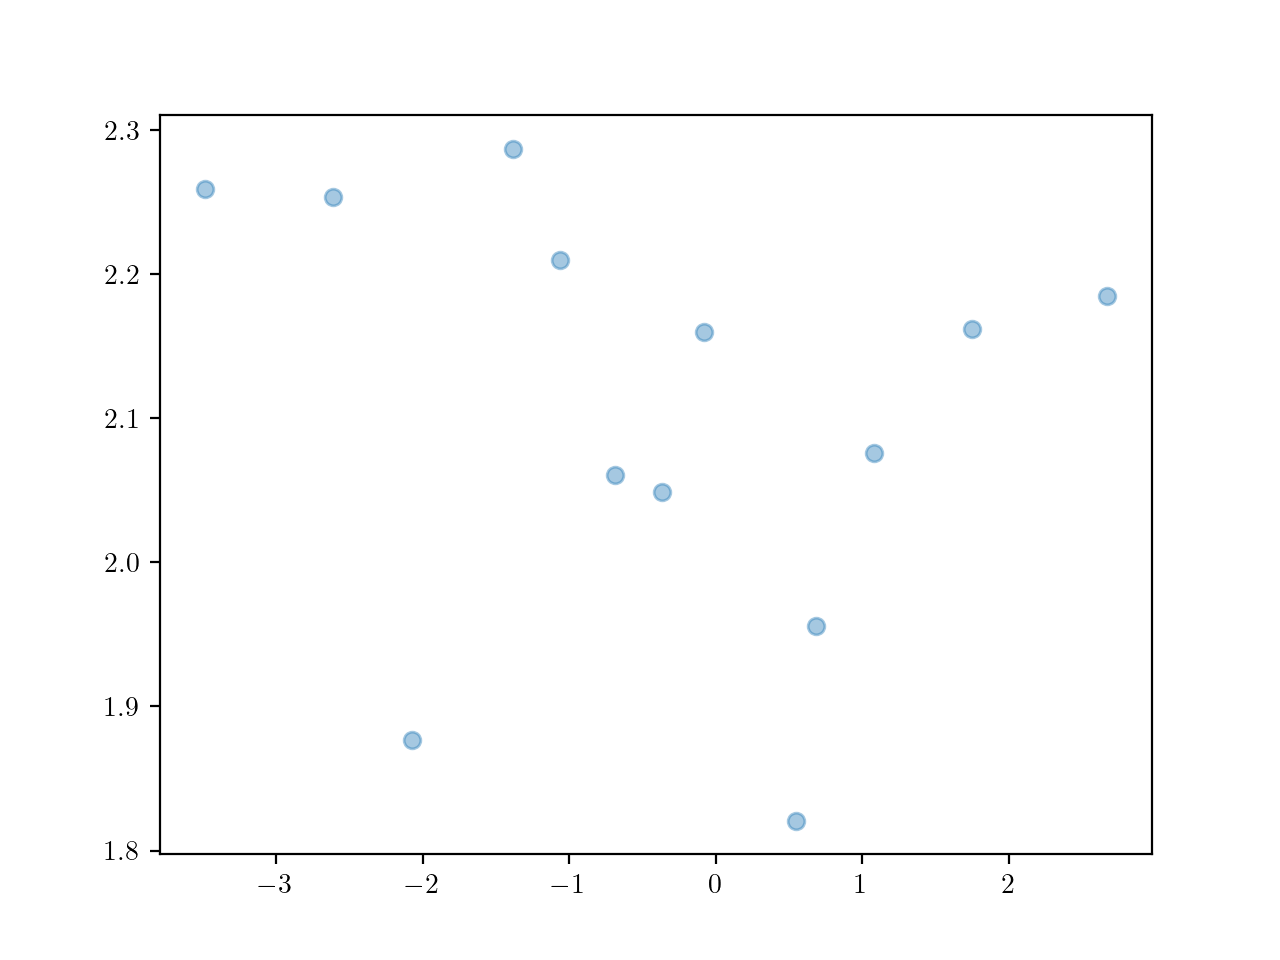

In [22]:
plot(w,sh,'o',alpha=.4)

In [23]:
L=16
st_lst,M2m=build_states_dimer_ladder(L)
H=Hamiltonian_dimer_ladder(L,st_lst,M2m)

In [24]:
w,v=eigh(H)
sh=[shannon_st(v[:,i]) for i in range(len(v))]

<IPython.core.display.Javascript object>


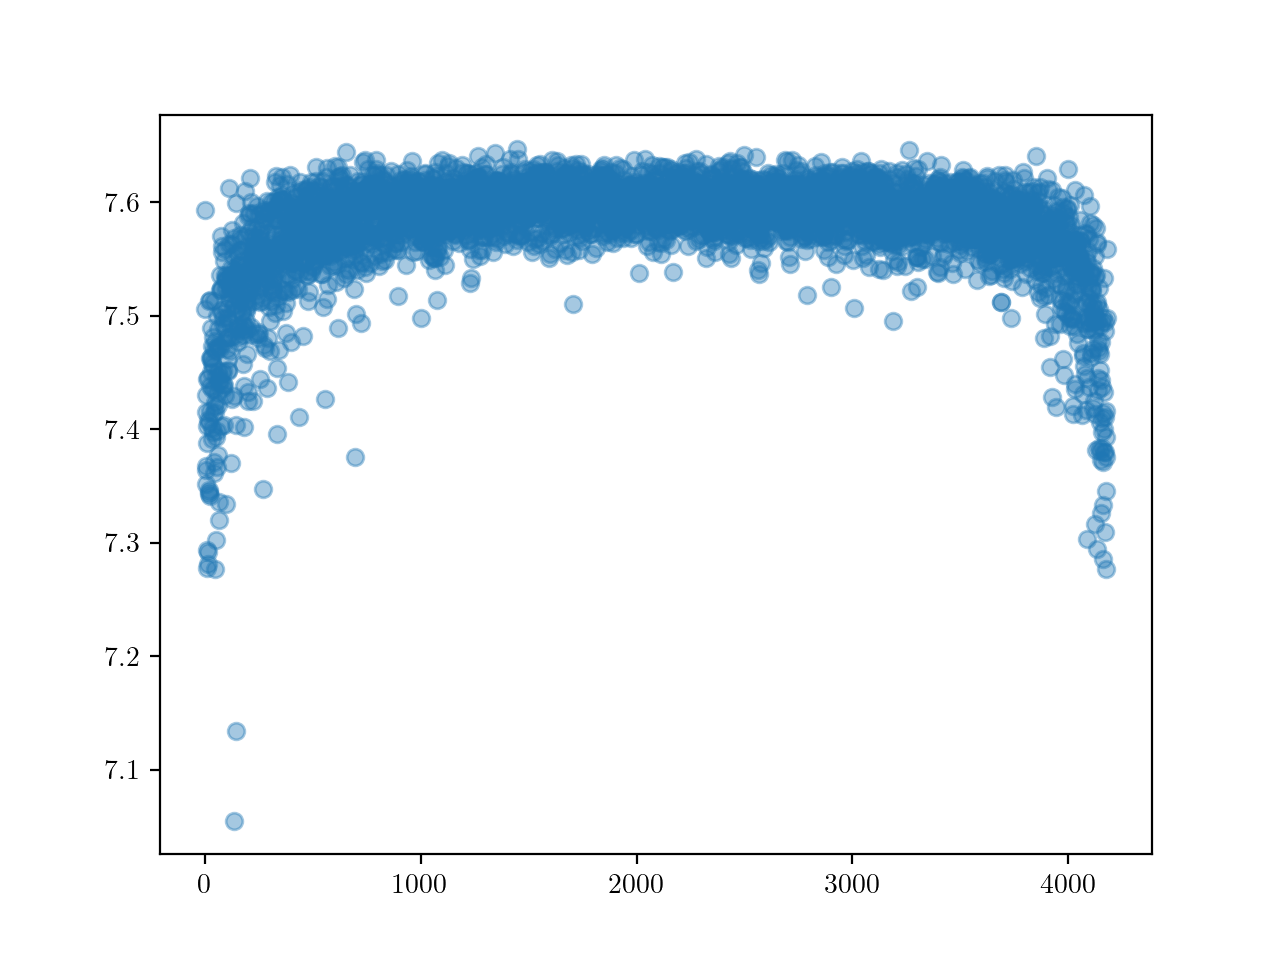

In [25]:
plot(range(len(sh)),sh,'o',alpha=.4)

In [26]:
L=16
st_lst,M2m=build_states_dimer_ladder(L)
H=Hamiltonian_dimer_ladder(L,st_lst,M2m)+.5*potential_dimer_ladder(L,st_lst)

In [27]:
w,v=eigh(H)
sh=[shannon_st(v[:,i]) for i in range(len(v))]

<IPython.core.display.Javascript object>


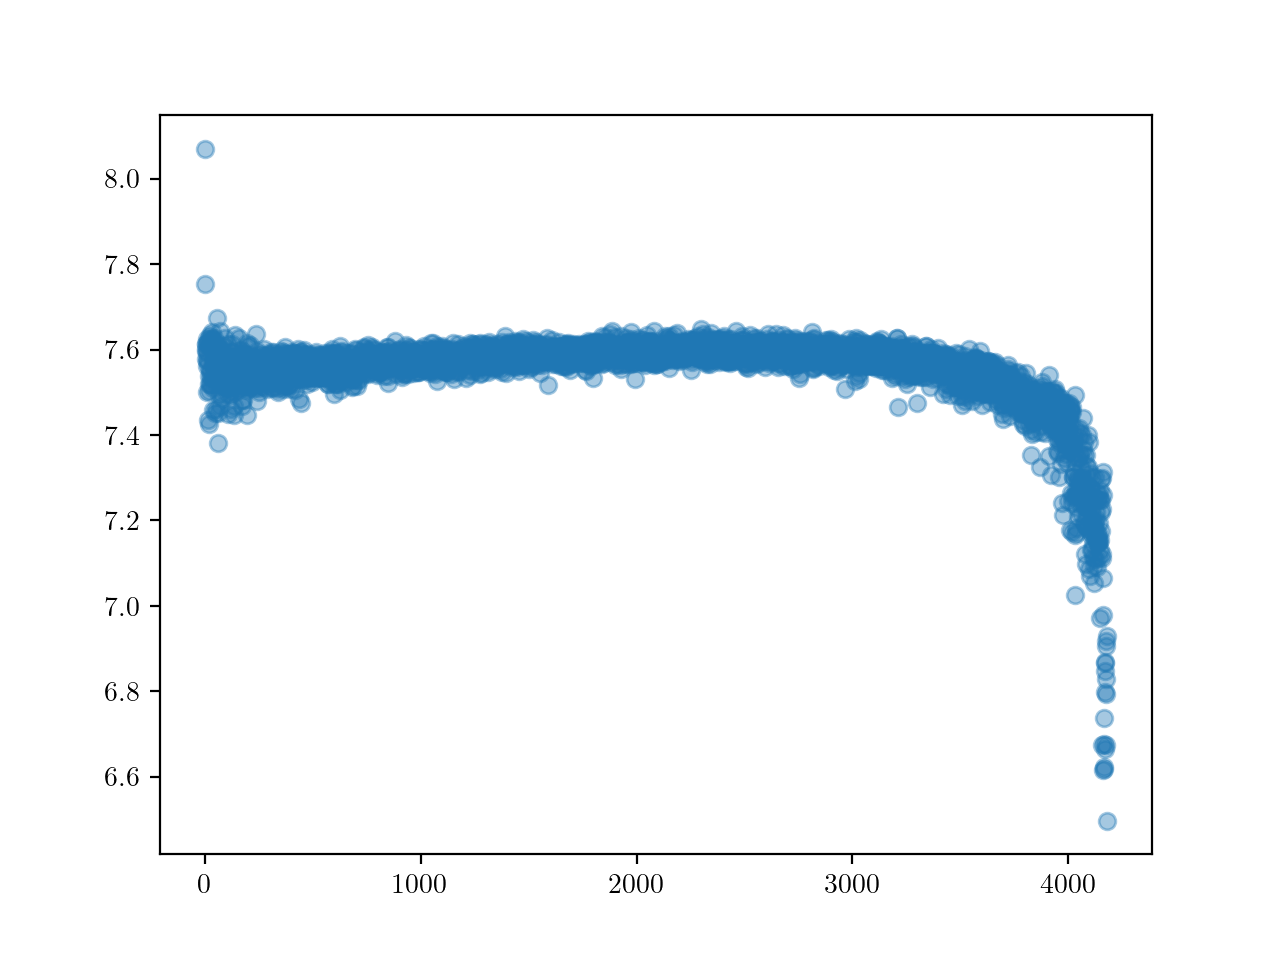

In [28]:
plot(range(len(sh)),sh,'o',alpha=.4)

In [29]:
L=16
st_lst,M2m=build_states_dimer_ladder(L)
H=Hamiltonian_dimer_ladder(L,st_lst,M2m)+.1*potential_dimer_ladder(L,st_lst)

In [30]:
w,v=eigh(H)
sh=[shannon_st(v[:,i]) for i in range(len(v))]

<IPython.core.display.Javascript object>


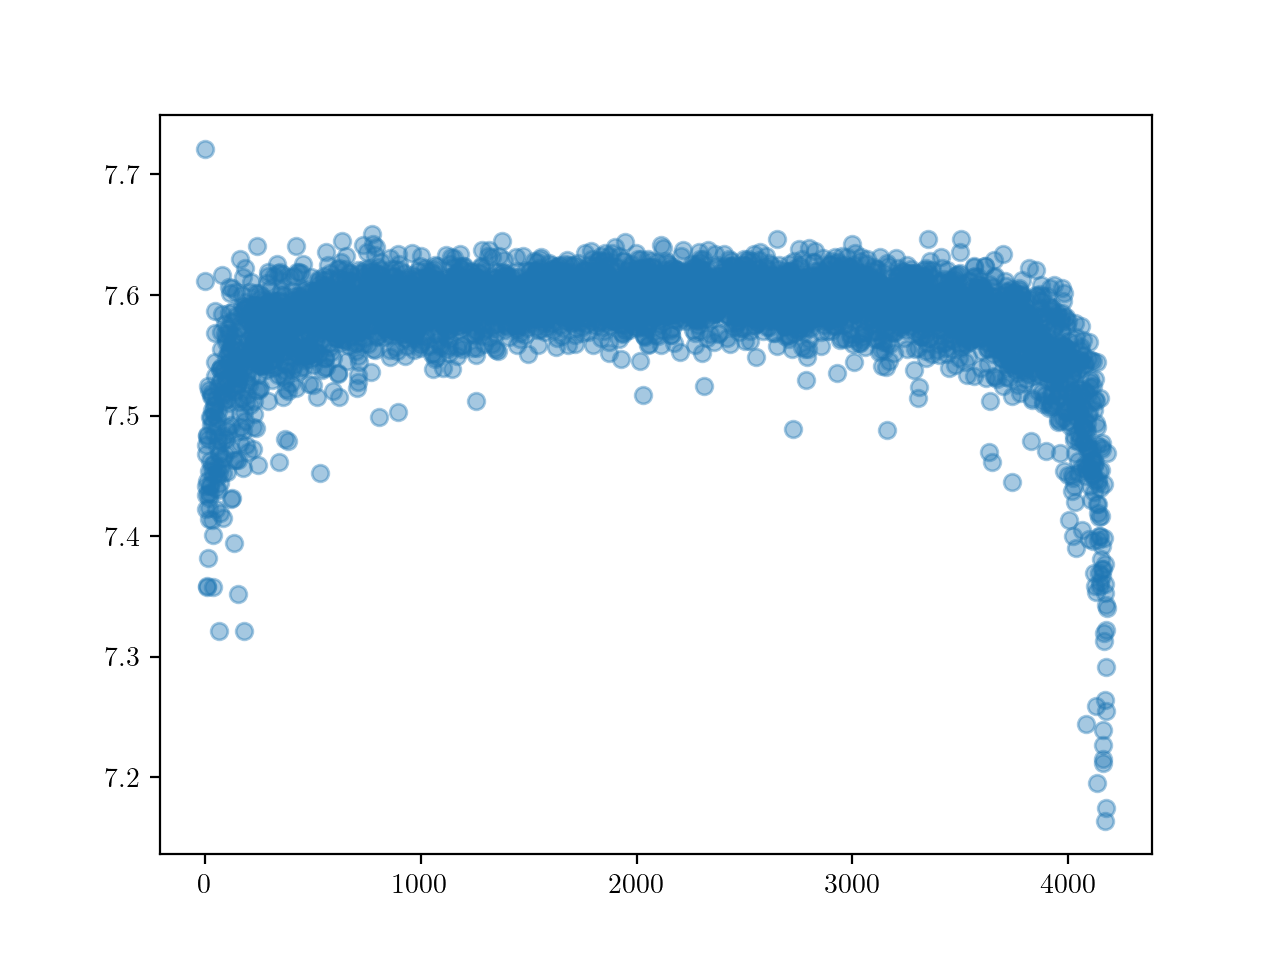

In [31]:
plot(range(len(sh)),sh,'o',alpha=.4)

In [32]:
L=16
st_lst,M2m=build_states_dimer_ladder(L)
H=Hamiltonian_dimer_ladder(L,st_lst,M2m)-.1*potential_dimer_ladder(L,st_lst)

In [33]:
w,v=eigh(H)
sh=[shannon_st(v[:,i]) for i in range(len(v))]

<IPython.core.display.Javascript object>


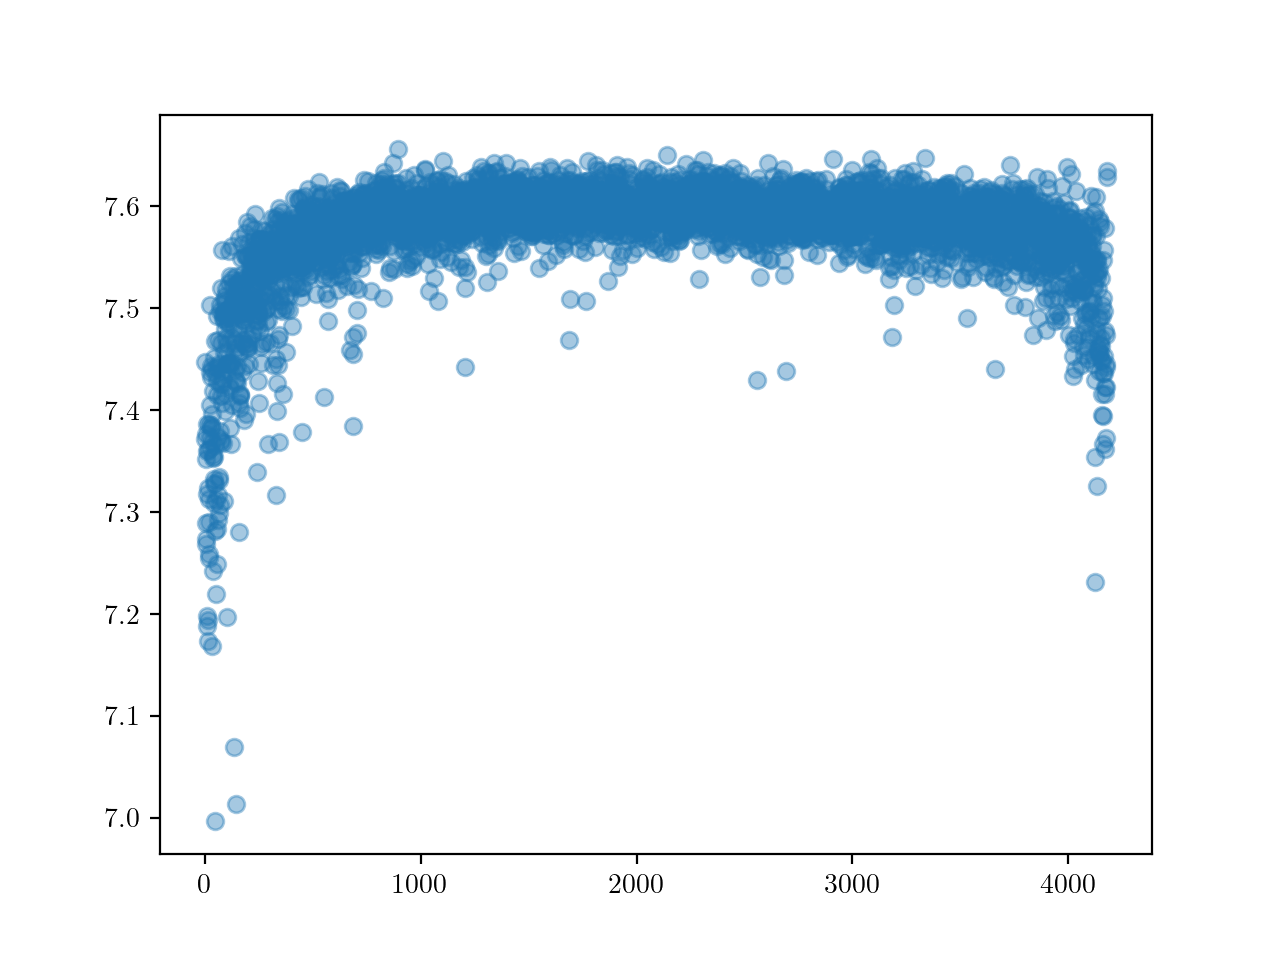

In [34]:
plot(range(len(sh)),sh,'o',alpha=.4)

In [28]:
stts4_2 = construction_states(4,2)

In [31]:
M2m,m2M=stts_to_dic(stts4_2,4,2)

In [32]:
Ok42=Ok(4,2,stts4_2,M2m,m2M)
Op42=Op(4,2,stts4_2,M2m,m2M)

In [33]:
w,v=eigh(Ok42-0.1*Op42)

In [34]:
sh=[shannon_st(v[:,i]) for i in range(len(v))]

<IPython.core.display.Javascript object>


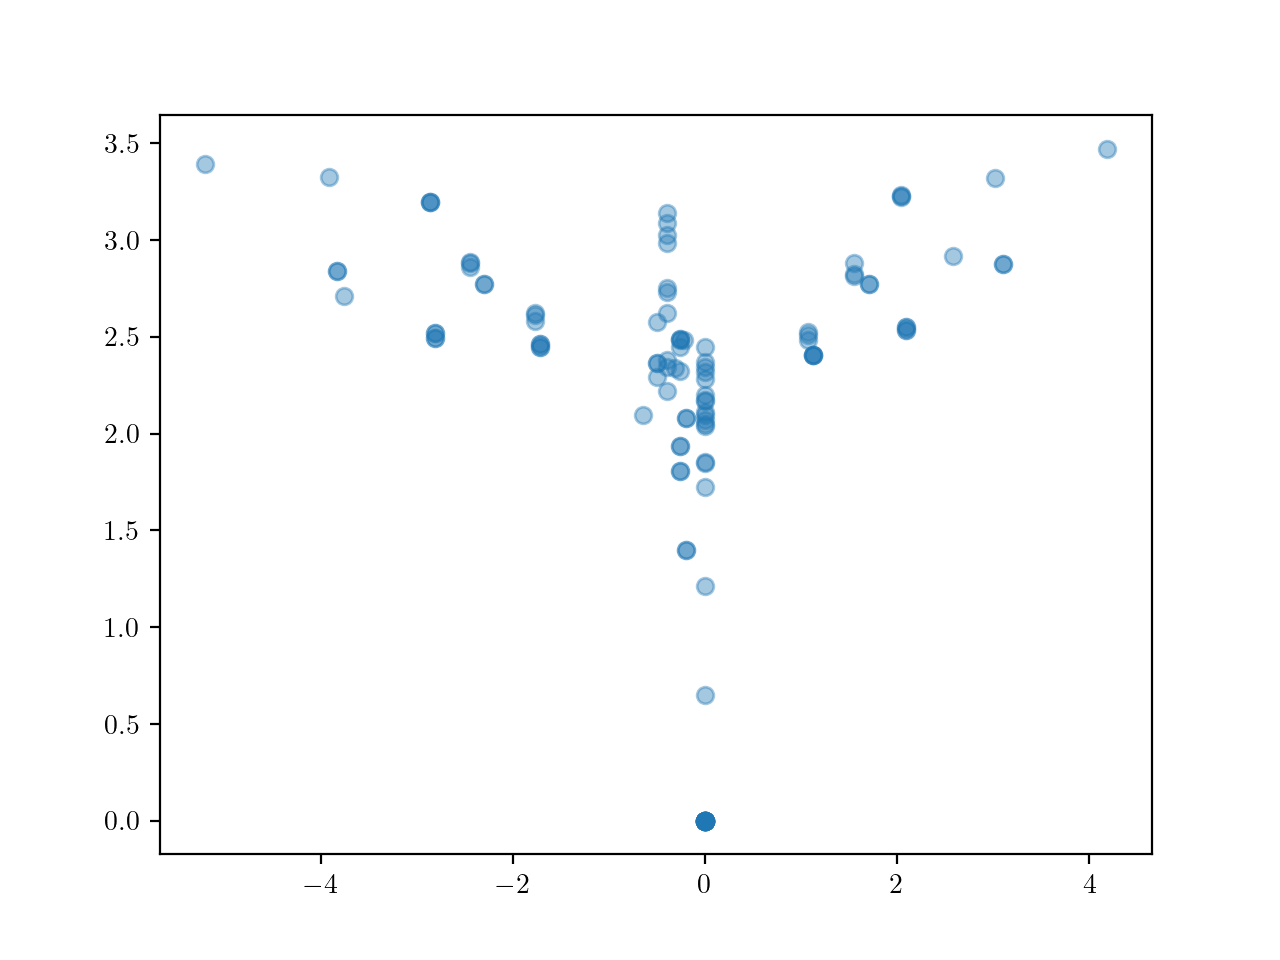

In [35]:
plot(w,sh,'o',alpha=.4)

<IPython.core.display.Javascript object>


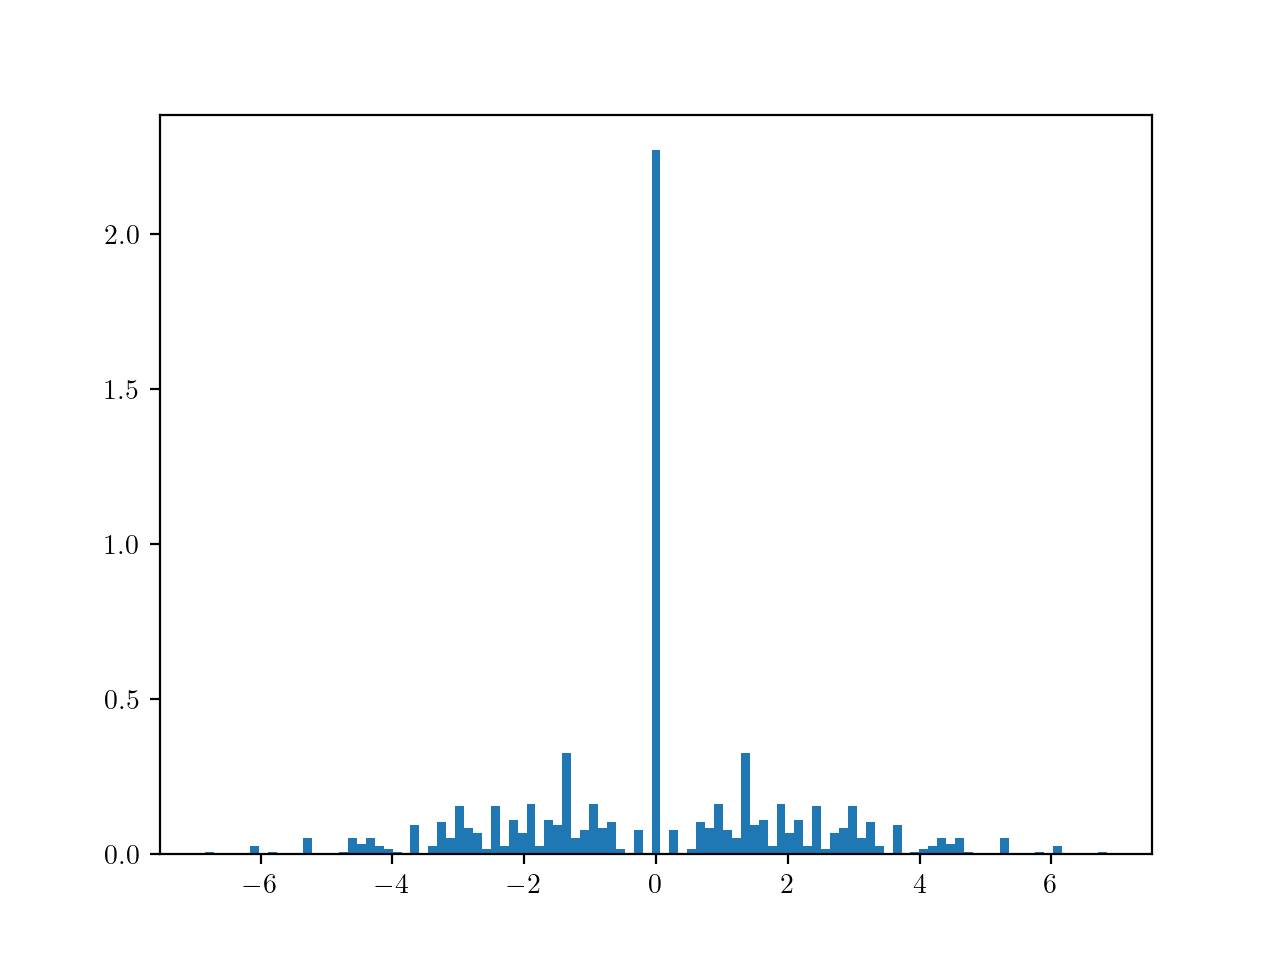

(array([0.00860144, 0.        , 0.        , 0.        , 0.        ,
        0.02580431, 0.        , 0.00860144, 0.        , 0.        ,
        0.        , 0.05160863, 0.        , 0.        , 0.        ,
        0.00860144, 0.05160863, 0.03440575, 0.05160863, 0.02580431,
        0.01720288, 0.00860144, 0.        , 0.09461581, 0.        ,
        0.02580431, 0.10321725, 0.05160863, 0.15482588, 0.08601438,
        0.0688115 , 0.01720288, 0.15482588, 0.02580431, 0.11181869,
        0.0688115 , 0.16342731, 0.02580431, 0.11181869, 0.09461581,
        0.32685463, 0.05160863, 0.07741294, 0.16342731, 0.08601438,
        0.10321725, 0.01720288, 0.        , 0.07741294, 0.        ,
        2.27077952, 0.        , 0.07741294, 0.        , 0.01720288,
        0.10321725, 0.08601438, 0.16342731, 0.07741294, 0.05160863,
        0.32685463, 0.09461581, 0.11181869, 0.02580431, 0.16342731,
        0.0688115 , 0.11181869, 0.02580431, 0.15482588, 0.01720288,
        0.0688115 , 0.08601438, 0.15482588, 0.05

In [22]:
hist(w,bins=101,density=True)

In [47]:
stts2_2

[array([[0, 0],
        [0, 0]]),
 array([[0, 4],
        [0, 4]]),
 array([[0, 0],
        [1, 1]]),
 array([[0, 4],
        [1, 5]]),
 array([[1, 1],
        [0, 0]]),
 array([[1, 5],
        [0, 4]]),
 array([[1, 1],
        [1, 1]]),
 array([[1, 5],
        [1, 5]]),
 array([[2, 3],
        [3, 2]]),
 array([[3, 2],
        [2, 3]]),
 array([[4, 0],
        [4, 0]]),
 array([[4, 4],
        [4, 4]]),
 array([[4, 0],
        [5, 1]]),
 array([[4, 4],
        [5, 5]]),
 array([[5, 1],
        [4, 0]]),
 array([[5, 5],
        [4, 4]]),
 array([[5, 1],
        [5, 1]]),
 array([[5, 5],
        [5, 5]])]

In [48]:
M2m,m2M=stts_to_dic(stts2_2,2,2)

In [49]:
Ok22=Ok(2,2,stts2_2,M2m,m2M)
Op22=Op(2,2,stts2_2,M2m,m2M)

In [51]:
Op22

array([[0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 2.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j],
       [0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 2.+0.j, 0.+0.j, 0.+0.j,
        0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
        0.+

In [52]:
w,v=eigh(Ok22-0.5*Op22)

<IPython.core.display.Javascript object>


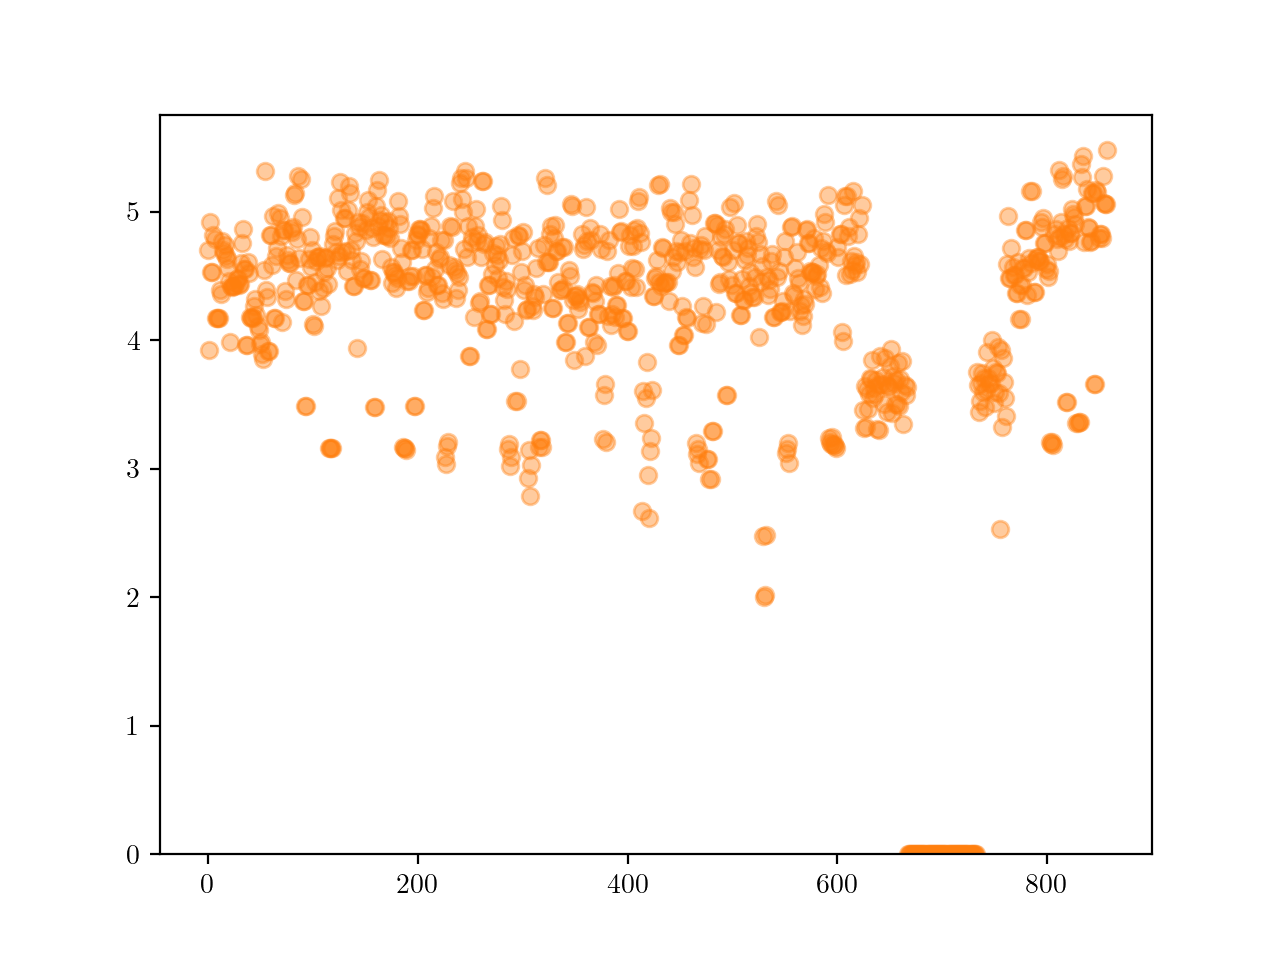

(array([0.40740741, 0.        , 0.        , 0.81481481, 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ,
        2.44444444]),
 array([-3.        , -2.72727273, -2.45454545, -2.18181818, -1.90909091,
        -1.63636364, -1.36363636, -1.09090909, -0.81818182, -0.54545455,
        -0.27272727,  0.        ]),
 <BarContainer object of 11 artists>)

In [54]:
hist(w,bins=11,density=True)